# 深度学习工艺模拟器

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from typing import Literal
from datetime import timedelta
from torchmetrics import MeanAbsolutePercentageError, MeanAbsoluteError

# 设备无关性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 生成虚拟数据

In [2]:
def generate_water_treatment_data(n_samples=10000, noise_level=0.1, 
                                  time_influence=0.2, past_influence=0.3, seed_value=42):
    """
    Generates synthetic water treatment process data with English column names, incorporating 
    the influence of past timesteps.

    Args:
        n_samples (int): Number of samples. Defaults to 10000.
        noise_level (float): Noise level. Defaults to 0.1.
        time_influence (float): Influence of time (days and hours) on effluent quality. 
                               Defaults to 0.2.
        past_influence (float): Influence of past values on current effluent quality.
                                Defaults to 0.3.
        seed_value (int): Seed value for random number generation. Defaults to 42.

    Returns:
        pd.DataFrame: DataFrame containing the synthetic data.
    """
    
    # Set the random seed
    np.random.seed(seed_value)
    
    # Create time variables
    hours = np.tile(np.arange(24), n_samples // 24 + 1)[:n_samples]
    days = np.repeat(np.arange(1, n_samples // 24 + 2), 24)[:n_samples]
    days = np.where(days > 365, days % 365, days)

    # Create influent quality variables
    influent_quality = pd.DataFrame(np.random.rand(n_samples, 6) * 10,
                                    columns=[f"Influent_{i+1}" for i in range(6)])
    for i in range(6):
        influent_quality[f"Influent_{i+1}"] += (
            2 * np.sin(2 * np.pi * days / 365) + np.random.normal(0, 1, n_samples)
        )

    # Create dosage variables
    dosage = pd.DataFrame(np.random.rand(n_samples, 4) * 2,
                          columns=[f"Dosage_{i+1}" for i in range(4)])

    # Create effluent quality variables, initialized with zeros
    effluent_quality = pd.DataFrame(np.zeros((n_samples, 5)),
                                     columns=[f"Effluent_{i+1}" for i in range(5)])

    # Loop through each timestep
    for t in range(n_samples):
        for i in range(5):
            # Current timestep influence
            influent_i = influent_quality.loc[t, f"Influent_{i+1}"]
            dosage_i = dosage.loc[t, f"Dosage_{i%4+1}"]
            current_influence = (
                0.5 * influent_i +
                2 * dosage_i -
                0.1 * influent_i * dosage_i +
                0.05 * influent_i**2 +
                time_influence * (
                    np.sin(2 * np.pi * hours[t] / 24) +
                    np.cos(2 * np.pi * days[t] / 365)
                )
            )

            # Past timesteps influence (up to 12 steps back)
            past_timesteps_influence = 0
            for past_t in range(1, min(t + 1, 13)):  # Look back up to 12 steps
                past_timesteps_influence += (
                    past_influence * (
                        0.1 * influent_quality.loc[t - past_t, f"Influent_{i+1}"] +
                        0.05 * dosage.loc[t - past_t, f"Dosage_{i%4+1}"] +
                        0.2 * effluent_quality.loc[t - past_t, f"Effluent_{i+1}"]
                    ) / past_t  # Divide by past_t to decrease influence with time
                )

            effluent_quality.loc[t, f"Effluent_{i+1}"] = np.clip(
                current_influence + past_timesteps_influence + np.random.normal(0, noise_level),
                a_min=0, a_max=None
            )

    # Combine all variables into a DataFrame
    df = pd.DataFrame({'Day': days, 'Hour': hours})
    df = pd.concat([df, influent_quality, dosage, effluent_quality], axis=1)

    return df

# Generate example data and measure time
start_time = time.time()
df = generate_water_treatment_data(n_samples=10000, noise_level=0.1, time_influence=0.2)
end_time = time.time()

# Print shape and time taken
print(f"Time taken to generate data: {end_time - start_time:.1f} seconds")
print("\nShape of generated data:", df.shape)
# Check memory usage
total_memory_usage = df.memory_usage(deep=True).sum()
print(f"Total memory usage: {total_memory_usage / 10**6:.2f} MB")
# Print the dataframe
print("")
print(df.head())

Time taken to generate data: 21.3 seconds

Shape of generated data: (10000, 17)
Total memory usage: 1.28 MB

   Day  Hour  Influent_1  Influent_2  Influent_3  Influent_4  Influent_5  \
0    1     0    4.321135    9.305705    7.034864    5.890778    0.168139   
1    1     1    0.958361    9.702080    5.834462    9.459600   -0.988381   
2    1     2    6.543964    1.778528    0.674542    2.389353    2.129426   
3    1     3    4.036905    2.614107    5.242256    2.513266    1.789560   
4    1     4    5.758987    7.593811    1.958494    5.993620    6.983989   

   Influent_6  Dosage_1  Dosage_2  Dosage_3  Dosage_4  Effluent_1  Effluent_2  \
0    0.537168  0.046678  0.646341  0.616521  0.149689    3.351548    9.808564   
1   10.341447  0.671645  1.205472  0.753963  0.041497    2.506776   11.714633   
2    7.055108  1.251682  0.611094  1.996920  1.799316    7.607195    3.927128   
3    4.059270  0.975117  0.736465  0.139175  0.002953    5.595812    4.564779   
4    3.556582  1.597311  0.98

## 将数据归一化

In [3]:
class DataPreprocessor:
    def __init__(self, scaler_type: Literal["minmax", "standard"] = "minmax", 
                 cyclic_time: bool = True):
        """Initializes the data preprocessor."""
        self.scaler_type = scaler_type
        self.cyclic_time = cyclic_time

        if self.scaler_type == "minmax":
            self.scaler = MinMaxScaler()
            self.scaler_effluent = MinMaxScaler()
            self.scaler_other = MinMaxScaler()
        elif self.scaler_type == "standard":
            self.scaler = StandardScaler()
            self.scaler_effluent = StandardScaler()
            self.scaler_other = StandardScaler()
        else:
            raise ValueError("Invalid scaler_type. Choose 'minmax' or 'standard'.")

    def fit(self, train_df: pd.DataFrame):
        """Fits the scaler based on the training data."""
        train_df_processed = train_df.copy()

        if self.cyclic_time:
            train_df_processed = self._time_to_cyclic(train_df_processed)

        self.scaler.fit(train_df_processed)

        effluent_cols = [col for col in train_df_processed.columns if col.startswith("Effluent")]
        other_cols = [col for col in train_df_processed.columns if not col.startswith("Effluent")]

        self.scaler_effluent.fit(train_df_processed[effluent_cols])
        self.scaler_other.fit(train_df_processed[other_cols])

    def transform(self, df: pd.DataFrame):
        """Transforms the data using the fitted scaler and converts time variables."""
        df_processed = df.copy()
        if self.cyclic_time:
            df_processed = self._time_to_cyclic(df_processed)
        return self.scaler.transform(df_processed)

    def _time_to_cyclic(self, df: pd.DataFrame):
        """Converts time variables to cyclic functions."""
        df['Day'] = np.sin(2 * np.pi * df['Day'] / 365)
        df['Hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
        return df
        

# Split the dataset
train_cutoff_ratio = 0.8
val_cutoff_ratio = 0.9
train_cutoff = int(len(df) * train_cutoff_ratio)
val_cutoff = int(len(df) * val_cutoff_ratio)

train_df = df.iloc[:train_cutoff]
val_df = df.iloc[train_cutoff:val_cutoff]
test_df = df.iloc[val_cutoff:]

# Create and fit the preprocessor
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)

# Transform the data
train_data = preprocessor.transform(train_df)
val_data = preprocessor.transform(val_df)
test_data = preprocessor.transform(test_df)

# Convert numpy arrays back to DataFrames
train_df_scaled = pd.DataFrame(train_data, columns=df.columns)
val_df_scaled = pd.DataFrame(val_data, columns=df.columns)
test_df_scaled = pd.DataFrame(test_data, columns=df.columns)

# Combine DataFrames
df_scaled = pd.concat([train_df_scaled, val_df_scaled, test_df_scaled], ignore_index=True)

print("train_df 形状为：", train_df.shape)
print("val_df 形状为：", val_df.shape)
print("test_df 形状为：", test_df.shape)
print("\n归一化之前/之后的 df 形状为：", df.shape, ",", df_scaled.shape)

train_df 形状为： (8000, 17)
val_df 形状为： (1000, 17)
test_df 形状为： (1000, 17)

归一化之前/之后的 df 形状为： (10000, 17) , (10000, 17)


## 定义深度学习模型

### GRU

In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_dim_0, input_dim_1, hidden_dim, output_dim, mlp_dim, 
                 gru_num_layers=1, gru_bias=True, gru_dropout=0.0, mlp_dropout=0.1):
        """
        初始化 GRU 模型。

        Args:
            input_dim_0 (int): GRU 输入的维度.
            input_dim_1 (int): 第二个输入的维度.
            hidden_dim (int): GRU 隐藏层的维度.
            output_dim (int): 输出的维度.
            mlp_dim (int): MLP 隐藏层的维度.
            gru_num_layers (int, optional): GRU 的层数. Defaults to 1.
            gru_bias (bool, optional): GRU 是否使用偏置. Defaults to True.
            gru_dropout (float, optional): GRU 的 dropout 率. Defaults to 0.0.
            mlp_dropout (float, optional): MLP 的 dropout 率. Defaults to 0.5.
        """
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim_0, hidden_dim, num_layers=gru_num_layers, 
                           bias=gru_bias, batch_first=True, dropout=gru_dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + input_dim_1, mlp_dim),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_dim, output_dim)
        )

    def forward(self, x):
        gru_input, other_input = x

        # GRU 部分
        # gru_input: (batch_size, lookback, input_dim_0)
        out, _ = self.gru(gru_input)
        # out: (batch_size, lookback, hidden_dim)
        out = out[:, -1, :]
        # out: (batch_size, hidden_dim)

        # 连接其他输入
        # other_input: (batch_size, input_dim_1)
        combined_input = torch.cat((out, other_input), dim=1)
        # combined_input: (batch_size, hidden_dim + input_dim_1)

        # MLP
        out = self.mlp(combined_input)
        # out: (batch_size, output_dim)
        return out

### LSTM

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim_0, input_dim_1, hidden_dim, output_dim, mlp_dim, 
                 lstm_num_layers=1, lstm_bias=True, lstm_dropout=0.0, mlp_dropout=0.1):
        """
        初始化 LSTM 模型。

        Args:
            input_dim_0 (int): LSTM 输入的维度.
            input_dim_1 (int):  第二个输入的维度.
            hidden_dim (int): LSTM 隐藏层的维度.
            output_dim (int): 输出的维度.
            mlp_dim (int): MLP 隐藏层的维度.
            lstm_num_layers (int, optional): LSTM 的层数. Defaults to 1.
            lstm_bias (bool, optional): LSTM 是否使用偏置. Defaults to True.
            lstm_dropout (float, optional): LSTM 的 dropout 率. Defaults to 0.0.
            mlp_dropout (float, optional): MLP 的 dropout 率. Defaults to 0.5.
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim_0, hidden_dim, num_layers=lstm_num_layers, 
                            bias=lstm_bias, batch_first=True, dropout=lstm_dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + input_dim_1, mlp_dim),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_dim, output_dim)
        )

    def forward(self, x):
        lstm_input, other_input = x

        # LSTM 部分
        # lstm_input: (batch_size, lookback, input_dim_0)
        out, _ = self.lstm(lstm_input)
        # out: (batch_size, lookback, hidden_dim)
        out = out[:, -1, :]
        # out: (batch_size, hidden_dim)

        # 连接其他输入
        # other_input: (batch_size, input_dim_1)
        combined_input = torch.cat((out, other_input), dim=1)
        # combined_input: (batch_size, hidden_dim + input_dim_1)

        # MLP
        out = self.mlp(combined_input)
        # out: (batch_size, output_dim)
        return out

### Transformer

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim_0=None, input_dim_1=None, 
                 hidden_dim=None, output_dim=None, seq_len=None,
                 nhead=4, nlayers=2, embedding_dropout=0.1, dim_feedforward=2048, 
                 transformer_dropout=0.1, activation=F.relu, norm_first=False, 
                 transformer_bias=True, mlp_dropout=0.1, mlp_dim=None):
        """
        初始化 Transformer 模型。

        Args:
            input_dim_0 (int): Transformer 输入的维度.
            input_dim_1 (int): 第二个输入的维度.
            hidden_dim (int): Transformer 隐藏层的维度.
            output_dim (int): 输出的维度.
            seq_len (int): 过去变量的长度 (序列长度).
            nhead (int, optional): 多头注意力机制的头数. Defaults to 4.
            nlayers (int, optional): Transformer 编码器层的数量. Defaults to 2.
            embedding_dropout (float, optional): 位置嵌入后的 dropout 率. Defaults to 0.1.
            dim_feedforward (int, optional): Transformer 前馈网络的维度. Defaults to 2048.
            transformer_dropout (float, optional): 
                Transformer 编码器层的 dropout 率. Defaults to 0.1.
            activation (Callable[..., torch.Tensor], optional): 
                Transformer 编码器层中前馈网络的激活函数. 
                例如 F.relu 或 torch.sigmoid. Defaults to F.relu.
            norm_first (bool, optional): 如果为 True，则在多头注意力和
                前馈网络之前应用层归一化，否则在之后应用. Defaults to False.
            transformer_bias (bool, optional): Transformer 编码器层是否使用偏置. Defaults to True.
            mlp_dropout (float, optional): MLP 的 dropout 率. Defaults to 0.5.
            mlp_dim (int, optional): MLP 隐藏层的维度. 
                如果为 None，则默认为 hidden_dim + input_dim_1. Defaults to None.
        """
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, 
                                                        dropout=transformer_dropout,
                                                        activation=activation, batch_first=True,
                                                        norm_first=norm_first, 
                                                        bias=transformer_bias)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.linear_embedding = nn.Linear(input_dim_0, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, hidden_dim))
        self.dropout = nn.Dropout(p=embedding_dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.token_embedding = nn.Parameter(torch.zeros(1, 1, hidden_dim))

        # 如果 mlp_dim 为 None，则使用默认值
        if mlp_dim is None:
            mlp_dim = hidden_dim + input_dim_1

        # MLP 部分
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + input_dim_1, mlp_dim),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_dim, output_dim)
        )


    def forward(self, x):
        transformer_input, other_input = x

        # Transformer 部分
        # transformer_input: (batch_size, seq_len, input_dim_0)
        batch_size, seq_len, input_dim_0 = transformer_input.shape
        x = self.linear_embedding(transformer_input)
        # x: (batch_size, seq_len, hidden_dim)
        x = x + self.pos_embedding  # Add positional encoding
        x = self.dropout(x)  # Apply dropout *after* positional encoding
        # x: (batch_size, seq_len, hidden_dim)

        token_embedding = self.token_embedding.repeat(batch_size, 1, 1)
        x = torch.cat((x, token_embedding), dim=1)
        # x: (batch_size, seq_len + 1, hidden_dim)
        x = self.transformer_encoder(x)
        # x: (batch_size, seq_len + 1, hidden_dim)
        x = self.layer_norm(x[:, -1, :])
        # x: (batch_size, hidden_dim)

        # 连接其他输入
        # other_input: (batch_size, input_dim_1)
        combined_input = torch.cat((x, other_input), dim=1)
        # combined_input: (batch_size, hidden_dim + input_dim_1)

        # MLP
        out = self.mlp(combined_input)
        # out: (batch_size, output_dim)
        return out

## 训练模型

### 构建深度学习样本

In [7]:
def create_sequences(df_scaled, seq_length=12):
    """
    Creates sequences for deep learning model.

    Args:
        df_scaled (pd.DataFrame): Scaled DataFrame.
        seq_length (int): Sequence length. Defaults to 12.

    Returns:
        tuple: x_0, x_1, y (NumPy arrays), n_samples (int).
    """
    n_samples = len(df_scaled) - seq_length

    n_features = len(df_scaled.columns)
    effluent_cols = [col for col in df_scaled.columns if col.startswith("Effluent")]
    other_cols = [col for col in df_scaled.columns if not col.startswith("Effluent")]

    x_0 = np.zeros((n_samples, seq_length, n_features))
    x_1 = np.zeros((n_samples, len(other_cols)))
    y = np.zeros((n_samples, len(effluent_cols)))

    for i in range(n_samples):
        x_0[i] = df_scaled.iloc[i:i + seq_length].values
        x_1[i] = df_scaled.iloc[i + seq_length][other_cols].values
        y[i] = df_scaled.iloc[i + seq_length][effluent_cols].values

    return x_0, x_1, y, n_samples


# 创建序列
SEQ_LENGTH = 12
x_0, x_1, y, n_samples = create_sequences(df_scaled, seq_length=SEQ_LENGTH)

# 生成深度学习训练、验证、测试数据
train_cutoff_seq = train_cutoff - SEQ_LENGTH
val_cutoff_seq = val_cutoff - SEQ_LENGTH

x_0_train = x_0[:train_cutoff_seq]
x_1_train = x_1[:train_cutoff_seq]
y_train = y[:train_cutoff_seq]

x_0_val = x_0[train_cutoff_seq:val_cutoff_seq]
x_1_val = x_1[train_cutoff_seq:val_cutoff_seq]
y_val = y[train_cutoff_seq:val_cutoff_seq]

x_0_test = x_0[val_cutoff_seq:]
x_1_test = x_1[val_cutoff_seq:]
y_test = y[val_cutoff_seq:]

# 打印信息
print(f"Number of deep learning samples available: {n_samples}")
print(f"Number of rows in original DataFrame: {len(df)}")

print("\n--- Training Data ---")
print(f"x_0_train shape: {x_0_train.shape}")
print(f"x_1_train shape: {x_1_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Validation Data ---")
print(f"x_0_val shape: {x_0_val.shape}")
print(f"x_1_val shape: {x_1_val.shape}")
print(f"y_val shape: {y_val.shape}")

print("\n--- Test Data ---")
print(f"x_0_test shape: {x_0_test.shape}")
print(f"x_1_test shape: {x_1_test.shape}")
print(f"y_test shape: {y_test.shape}")

Number of deep learning samples available: 9988
Number of rows in original DataFrame: 10000

--- Training Data ---
x_0_train shape: (7988, 12, 17)
x_1_train shape: (7988, 12)
y_train shape: (7988, 5)

--- Validation Data ---
x_0_val shape: (1000, 12, 17)
x_1_val shape: (1000, 12)
y_val shape: (1000, 5)

--- Test Data ---
x_0_test shape: (1000, 12, 17)
x_1_test shape: (1000, 12)
y_test shape: (1000, 5)


### 直接训练模型

**定义训练模型的函数：**

In [8]:
def train_model(model, train_loader, val_loader, criterion, patience=10, 
                lr_decay_factor=0.5, max_grad_norm=1.0, save_dir="./"):
    """
    训练模型，并在验证集损失停止改进时应用早停机制。

    Args:
        model: 要训练的 PyTorch 模型。
        train_loader: 训练数据的 DataLoader。
        val_loader: 验证数据的 DataLoader。
        criterion: 损失函数，例如 nn.MSELoss() 或 nn.CrossEntropyLoss()。
        patience: 早停的 patience 值，即在验证损失停止改进后继续训练的 epoch 数。
        lr_decay_factor: 学习率衰减因子，用于在 ReduceLROnPlateau 调度器中降低学习率。
        max_grad_norm: 用于梯度裁剪的最大梯度范数。
        save_dir: 保存最佳模型的目录路径。

    Returns:
        训练好的模型，加载了最佳状态字典。
    """

    # Adam 优化器：一种常用的基于梯度的优化算法，它适应性地调整每个参数的学习率。
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # ReduceLROnPlateau 学习率调度器：当验证损失 plateaus 时降低学习率。
    # patience 参数定义了在减少学习率之前要等待的 epoch 数。
    # factor 参数是每次减少学习率时乘以的因子。
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=lr_decay_factor
    )

    best_val_loss = float('inf')  # 初始化最佳验证损失为无穷大
    epochs_no_improve = 0  # 初始化没有改进的 epoch 数

    # 构建保存路径，确保目录存在
    save_path = os.path.join(save_dir, 'best_model.pt')
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(100):  # 循环遍历 epoch
        model.train()  # 将模型设置为训练模式
        train_loss = 0.0  # 初始化训练损失

        for x_0, x_1, y in train_loader:  # 循环遍历训练数据批次
            optimizer.zero_grad()  # 清零梯度，避免梯度累积

            outputs = model((x_0, x_1))  # 前向传播：通过模型计算预测输出
            loss = criterion(outputs, y)  # 计算损失：比较预测输出和真实标签

            loss.backward()  # 反向传播：计算损失相对于模型参数的梯度

            # 梯度裁剪：防止梯度爆炸，将梯度范数裁剪到最大值。
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()  # 更新模型参数：使用计算出的梯度更新模型参数
            train_loss += loss.item() * x_0.size(0)  # 累加训练损失

        model.eval()  # 将模型设置为评估模式
        val_loss = 0.0  # 初始化验证损失

        with torch.no_grad():  # 禁用梯度计算，以节省内存和时间
            for x_0, x_1, y in val_loader:  # 循环遍历验证数据批次
                outputs = model((x_0, x_1))  # 前向传播：通过模型计算预测输出
                loss = criterion(outputs, y)  # 计算损失
                val_loss += loss.item() * x_0.size(0)  # 累加验证损失

        train_loss /= len(train_loader.dataset)  # 计算平均训练损失
        val_loss /= len(val_loader.dataset)  # 计算平均验证损失

        scheduler.step(val_loss)  # 更新学习率调度器：根据验证损失调整学习率

        print(
            f"Epoch {epoch+1}/{100}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

        # 早停机制：如果验证损失没有改善，则增加 epochs_no_improve 计数器。
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # 更新最佳验证损失
            epochs_no_improve = 0  # 重置没有改进的 epoch 数
            torch.save(model.state_dict(), save_path)  # 保存最佳模型的状态字典
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:  # 如果没有改进的 epoch 数达到 patience 值
                print("Early stopping triggered!")  # 触发早停
                break  # 停止训练

    # 加载最佳模型的状态字典：确保返回的模型具有最佳性能。
    model.load_state_dict(torch.load(save_path))
    return model

**构建数据加载器：**

In [9]:
# 数据加载和预处理
batch_size = 32  # 根据需要调整

# 将 numpy 数组转换为 PyTorch 张量，并移动到设备
x_0_train = torch.tensor(x_0_train, dtype=torch.float32).to(device)
x_1_train = torch.tensor(x_1_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

x_0_val = torch.tensor(x_0_val, dtype=torch.float32).to(device)
x_1_val = torch.tensor(x_1_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

x_0_test = torch.tensor(x_0_test, dtype=torch.float32).to(device)
x_1_test = torch.tensor(x_1_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# 创建 DataLoader
train_dataset = torch.utils.data.TensorDataset(x_0_train, x_1_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_0_val, x_1_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_0_test, x_1_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### `GRUModel`

Epoch 1/100, Train Loss: 0.0168, Validation Loss: 0.0032
Epoch 2/100, Train Loss: 0.0034, Validation Loss: 0.0009
Epoch 3/100, Train Loss: 0.0021, Validation Loss: 0.0009
Epoch 4/100, Train Loss: 0.0018, Validation Loss: 0.0006
Epoch 5/100, Train Loss: 0.0015, Validation Loss: 0.0006
Epoch 6/100, Train Loss: 0.0013, Validation Loss: 0.0006
Epoch 7/100, Train Loss: 0.0012, Validation Loss: 0.0006
Epoch 8/100, Train Loss: 0.0011, Validation Loss: 0.0005
Epoch 9/100, Train Loss: 0.0010, Validation Loss: 0.0003
Epoch 10/100, Train Loss: 0.0009, Validation Loss: 0.0002
Epoch 11/100, Train Loss: 0.0009, Validation Loss: 0.0002
Epoch 12/100, Train Loss: 0.0009, Validation Loss: 0.0003
Epoch 13/100, Train Loss: 0.0008, Validation Loss: 0.0004
Epoch 14/100, Train Loss: 0.0008, Validation Loss: 0.0002
Epoch 15/100, Train Loss: 0.0008, Validation Loss: 0.0001
Epoch 16/100, Train Loss: 0.0008, Validation Loss: 0.0002
Epoch 17/100, Train Loss: 0.0007, Validation Loss: 0.0003
Epoch 18/100, Train Los

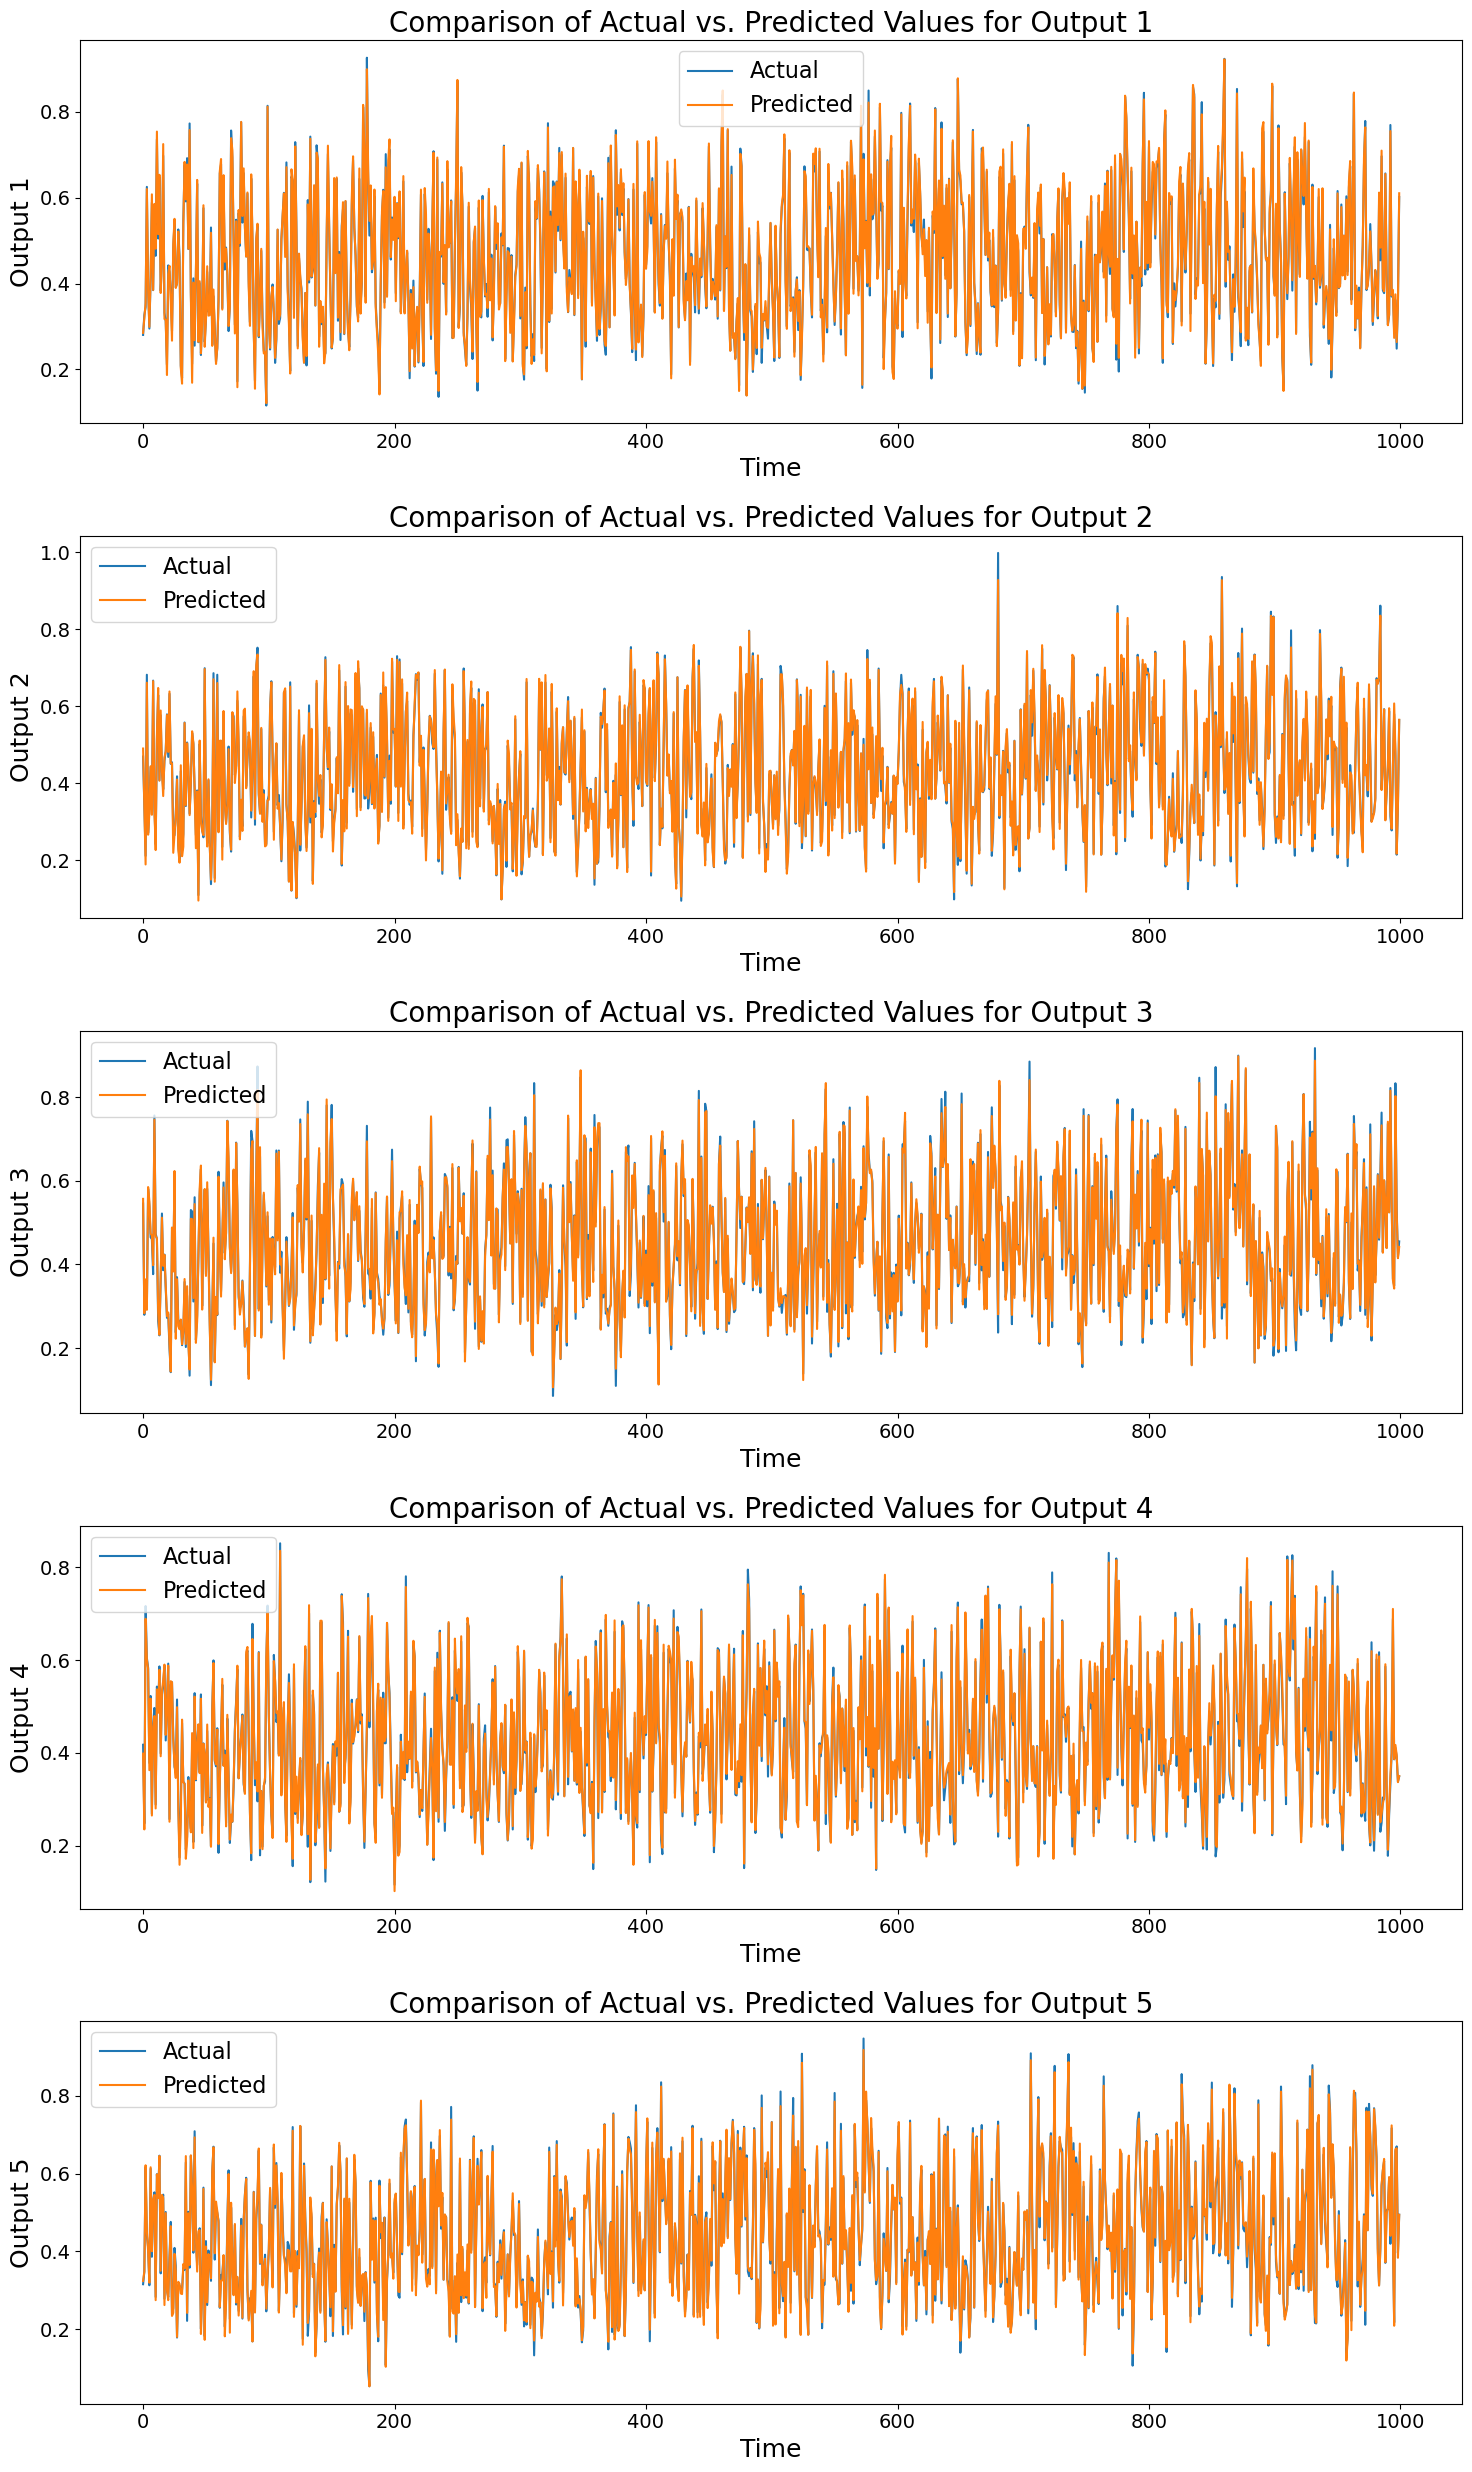

In [10]:
# 记录开始时间
start_time = time.time()

# 模型实例化和训练
input_dim_0 = x_0_train.shape[2]
input_dim_1 = x_1_train.shape[1]
hidden_dim = 64  # 可根据需要调整
output_dim = y_train.shape[1]
mlp_dim = 128 # 可根据需要调整

model_GRU = GRUModel(input_dim_0, input_dim_1, hidden_dim, output_dim, mlp_dim).to(device)
criterion = nn.MSELoss() 
model_GRU = train_model(model_GRU, train_loader, val_loader, criterion, 
                        save_dir=save_dir) # 传入 criterion

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"\n训练 GRUModel 模型总时间: {hours}时{minutes}分{seconds}秒")
print("")
print("-" * 88)


# 创建测试指标
mape_metric = MeanAbsolutePercentageError().to(device)
mae_metric = MeanAbsoluteError().to(device)

print("注意：torchmetrics 中的 MeanAbsolutePercentageError 方法并没有乘以 100！")

# 测试 - 直接使用测试张量
model_GRU.eval()
with torch.no_grad():
    test_outputs = model_GRU((x_0_test, x_1_test))
    test_loss = criterion(test_outputs, y_test)

    # 更新指标
    mape_metric.update(test_outputs, y_test)
    mae_metric.update(test_outputs, y_test)

mae = mae_metric.compute()
mape = mape_metric.compute() 

# 计算 MAE 占 y_test 均值的百分比
y_test_mean = y_test.mean()
mae_percentage = (mae / y_test_mean) * 100

print(f"\n测试损失: {test_loss:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")  # 乘以100，并添加百分号
print(f"MAE 占 y_test 平均值的百分比: {mae_percentage:.2f}%")  # 文字更清晰


# 绘图对比预测值和实际值
num_outputs = y_test.shape[1]  # 输出维度，即水质指标的数量
timesteps = y_test.shape[0] # 时间步，即行数

plt.figure(figsize=(15, 5 * num_outputs)) # 根据指标数量调整图像大小

# 设置全局字体大小
plt.rcParams.update({'font.size': 16})  # 将字体大小设置为 16

for i in range(num_outputs):
    plt.subplot(num_outputs, 1, i + 1)  # 创建子图
    plt.plot(range(timesteps), y_test[:, i].cpu().numpy(), label="Actual")  # 绘制实际值
    plt.plot(range(timesteps), test_outputs[:, i].cpu().numpy(), label="Predicted")  # 绘制预测值
    plt.xlabel("Time", fontsize=18) # 增大 x 轴标签字体大小
    plt.ylabel(f"Output {i+1}", fontsize=18)  # 增大 y 轴标签字体大小
    plt.title(f"Comparison of Actual vs. Predicted Values for Output {i+1}", fontsize=20) 
    plt.legend(fontsize=16)  # 增大图例字体大小
    plt.xticks(fontsize=14) # 增大 x 轴刻度字体大小
    plt.yticks(fontsize=14) # 增大 y 轴刻度字体大小

plt.tight_layout()  # 调整子图布局
plt.show()

#### `LSTMModel`

Epoch 1/100, Train Loss: 0.0159, Validation Loss: 0.0024
Epoch 2/100, Train Loss: 0.0029, Validation Loss: 0.0014
Epoch 3/100, Train Loss: 0.0019, Validation Loss: 0.0013
Epoch 4/100, Train Loss: 0.0015, Validation Loss: 0.0009
Epoch 5/100, Train Loss: 0.0013, Validation Loss: 0.0006
Epoch 6/100, Train Loss: 0.0012, Validation Loss: 0.0005
Epoch 7/100, Train Loss: 0.0011, Validation Loss: 0.0007
Epoch 8/100, Train Loss: 0.0010, Validation Loss: 0.0004
Epoch 9/100, Train Loss: 0.0009, Validation Loss: 0.0002
Epoch 10/100, Train Loss: 0.0009, Validation Loss: 0.0003
Epoch 11/100, Train Loss: 0.0008, Validation Loss: 0.0004
Epoch 12/100, Train Loss: 0.0008, Validation Loss: 0.0003
Epoch 13/100, Train Loss: 0.0007, Validation Loss: 0.0002
Epoch 14/100, Train Loss: 0.0007, Validation Loss: 0.0002
Epoch 15/100, Train Loss: 0.0007, Validation Loss: 0.0003
Epoch 16/100, Train Loss: 0.0007, Validation Loss: 0.0003
Epoch 17/100, Train Loss: 0.0007, Validation Loss: 0.0001
Epoch 18/100, Train Los

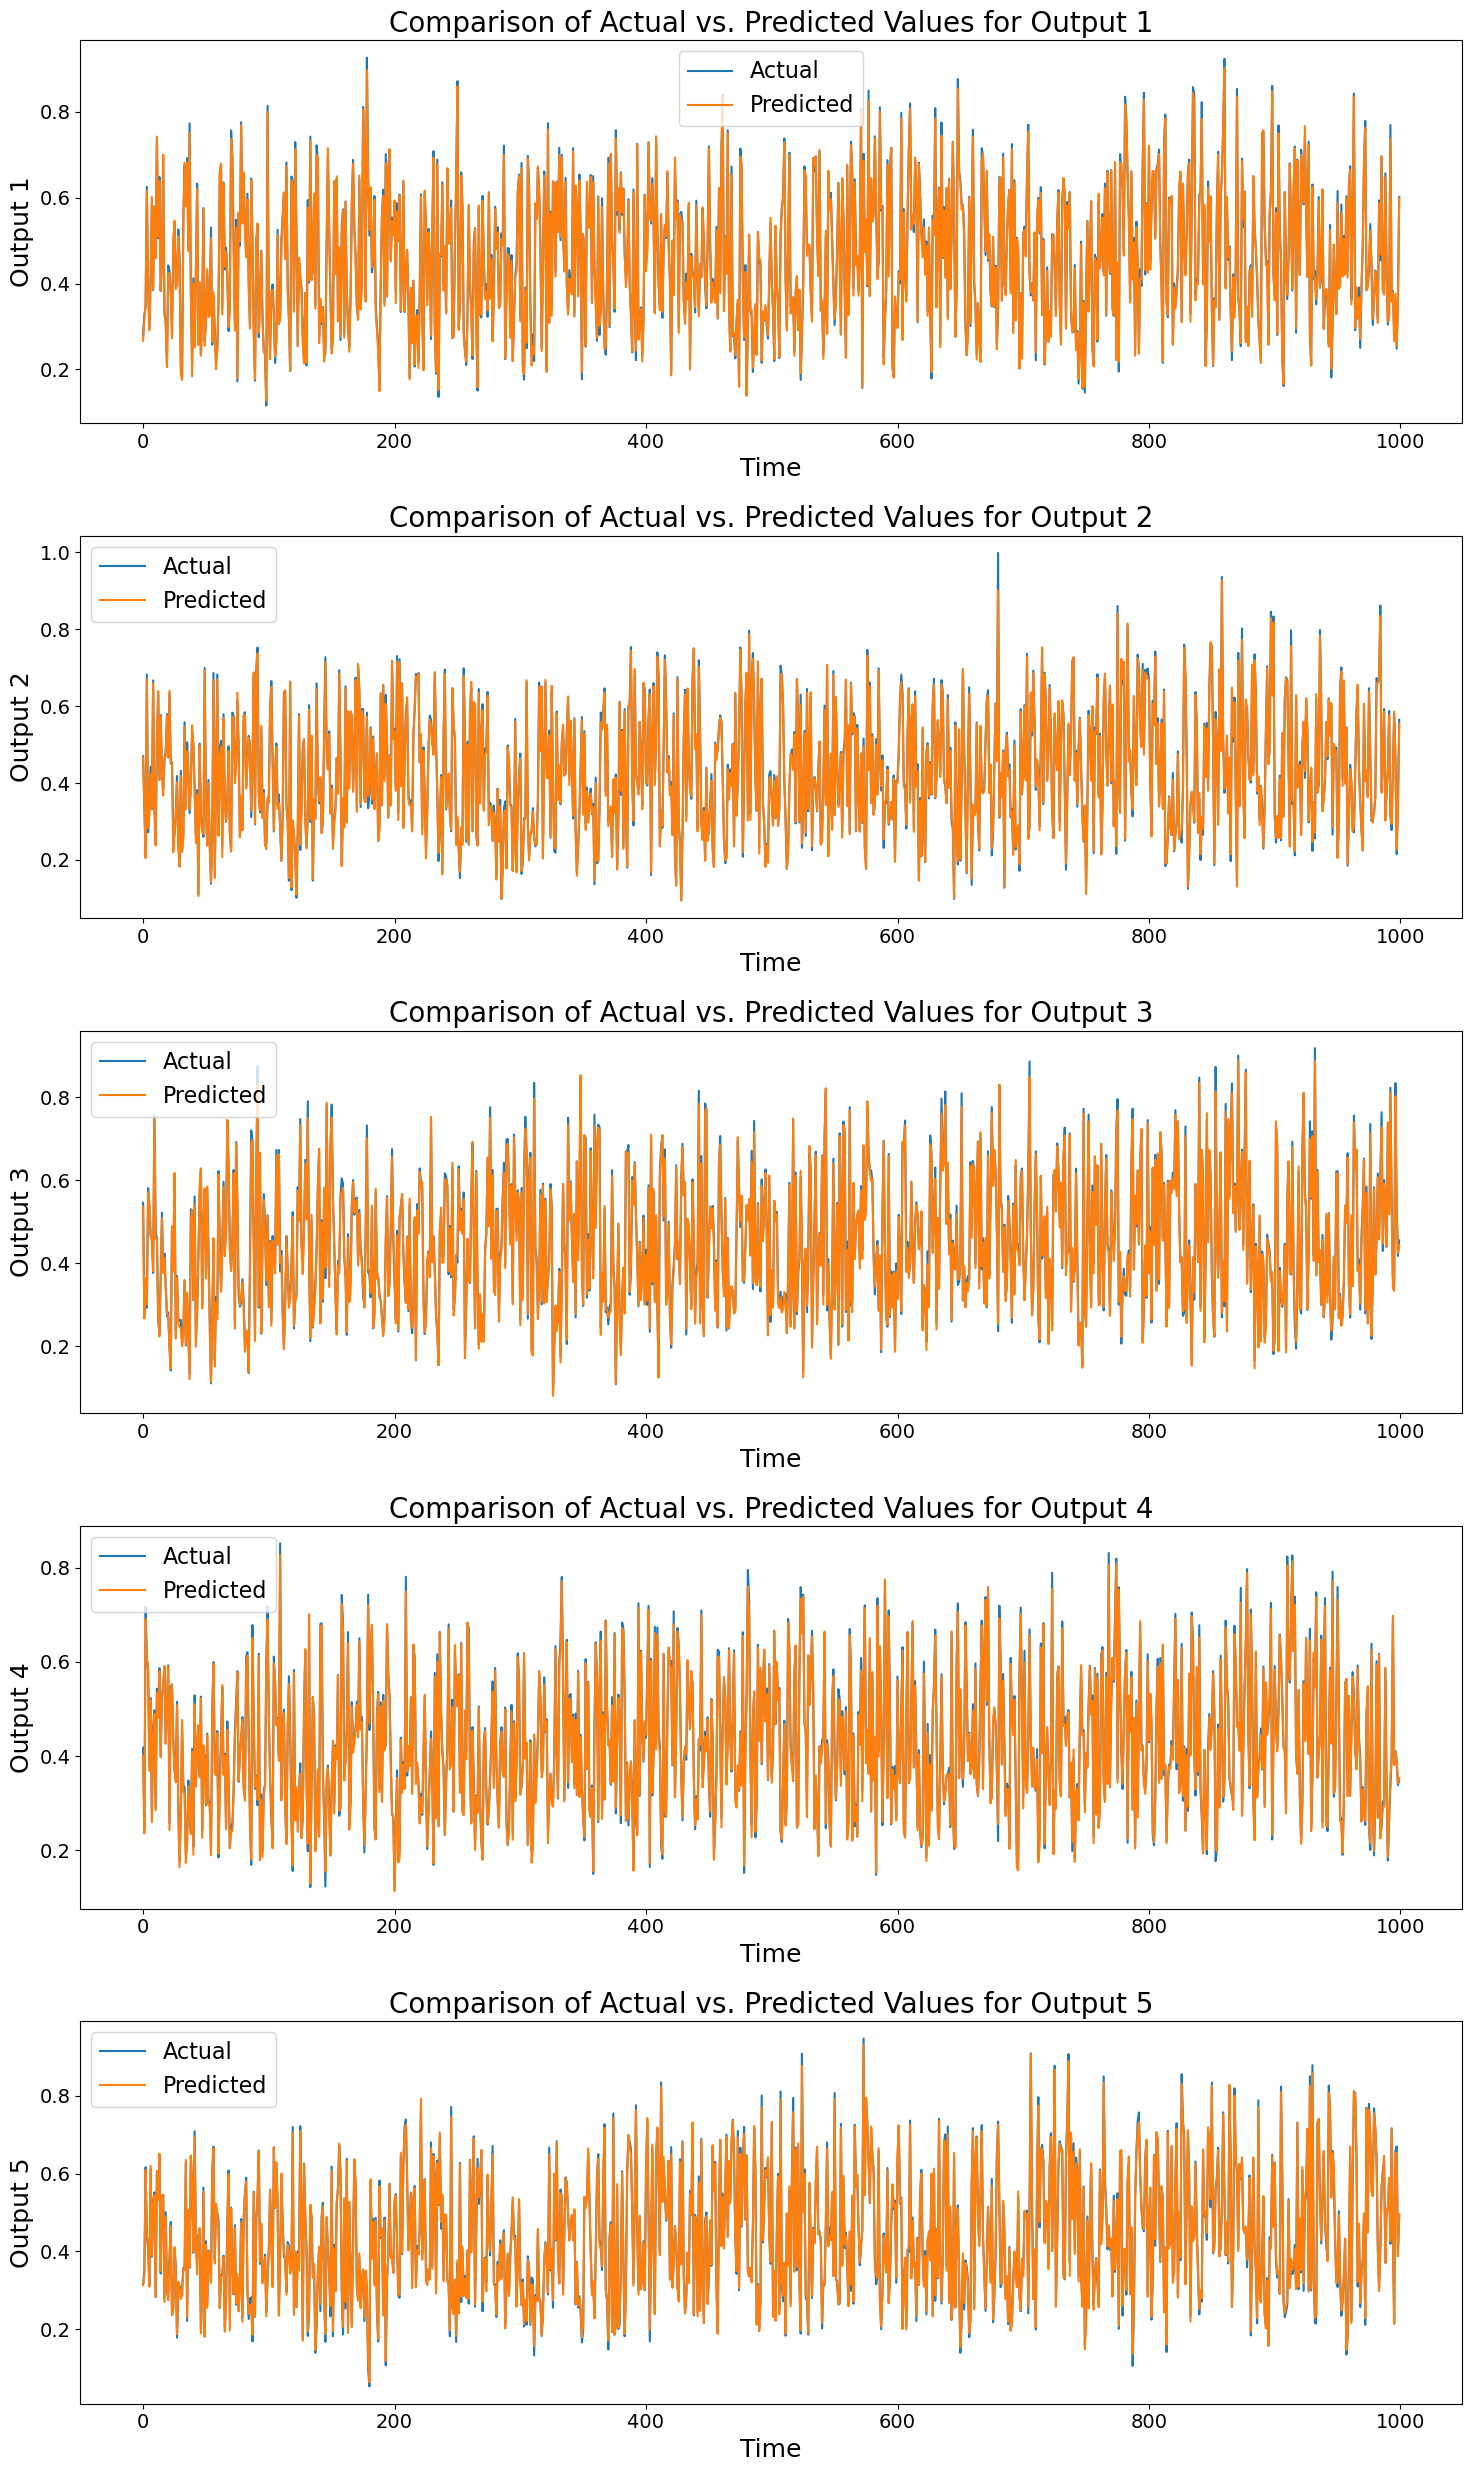

In [11]:
# 记录开始时间
start_time = time.time()

# 模型实例化和训练，使用 LSTMModel
input_dim_0 = x_0_train.shape[2]
input_dim_1 = x_1_train.shape[1]
hidden_dim = 64  # 可根据需要调整
output_dim = y_train.shape[1]
mlp_dim = 128 # 可根据需要调整

model_LSTM = LSTMModel(input_dim_0, input_dim_1, hidden_dim, 
                       output_dim, mlp_dim).to(device) # 使用 LSTMModel
criterion = nn.MSELoss()
model_LSTM = train_model(model_LSTM, train_loader, val_loader, criterion, 
                         save_dir=save_dir)  # 使用 LSTMModel 训练

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"\n训练 LSTMModel 模型总时间: {hours}时{minutes}分{seconds}秒")
print("")
print("-" * 88)


# 创建测试指标
mape_metric = MeanAbsolutePercentageError().to(device)
mae_metric = MeanAbsoluteError().to(device)

print("注意：torchmetrics 中的 MeanAbsolutePercentageError 方法并没有乘以 100！")

# 测试 - 直接使用测试张量，使用 LSTMModel
model_LSTM.eval() # 使用 LSTMModel
with torch.no_grad():
    test_outputs = model_LSTM((x_0_test, x_1_test)) # 使用 LSTMModel
    test_loss = criterion(test_outputs, y_test)

    # 更新指标
    mape_metric.update(test_outputs, y_test)
    mae_metric.update(test_outputs, y_test)

mae = mae_metric.compute()
mape = mape_metric.compute() 

# 计算 MAE 占 y_test 均值的百分比
y_test_mean = y_test.mean()
mae_percentage = (mae / y_test_mean) * 100

print(f"\n测试损失: {test_loss:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")  # 乘以100，并添加百分号
print(f"MAE 占 y_test 平均值的百分比: {mae_percentage:.2f}%")  # 文字更清晰


# 绘图对比预测值和实际值
num_outputs = y_test.shape[1]  # 输出维度，即水质指标的数量
timesteps = y_test.shape[0] # 时间步，即行数

plt.figure(figsize=(15, 5 * num_outputs)) # 根据指标数量调整图像大小

# 设置全局字体大小
plt.rcParams.update({'font.size': 16})  # 将字体大小设置为 16

for i in range(num_outputs):
    plt.subplot(num_outputs, 1, i + 1)  # 创建子图
    plt.plot(range(timesteps), y_test[:, i].cpu().numpy(), label="Actual")  # 绘制实际值
    plt.plot(range(timesteps), test_outputs[:, i].cpu().numpy(), label="Predicted")  # 绘制预测值
    plt.xlabel("Time", fontsize=18) # 增大 x 轴标签字体大小
    plt.ylabel(f"Output {i+1}", fontsize=18)  # 增大 y 轴标签字体大小
    plt.title(f"Comparison of Actual vs. Predicted Values for Output {i+1}", fontsize=20) 
    plt.legend(fontsize=16)  # 增大图例字体大小
    plt.xticks(fontsize=14) # 增大 x 轴刻度字体大小
    plt.yticks(fontsize=14) # 增大 y 轴刻度字体大小

plt.tight_layout()  # 调整子图布局
plt.show()

#### `TransformerModel`

Epoch 1/100, Train Loss: 0.0205, Validation Loss: 0.0077
Epoch 2/100, Train Loss: 0.0075, Validation Loss: 0.0016
Epoch 3/100, Train Loss: 0.0033, Validation Loss: 0.0011
Epoch 4/100, Train Loss: 0.0027, Validation Loss: 0.0014
Epoch 5/100, Train Loss: 0.0024, Validation Loss: 0.0011
Epoch 6/100, Train Loss: 0.0021, Validation Loss: 0.0011
Epoch 7/100, Train Loss: 0.0019, Validation Loss: 0.0012
Epoch 8/100, Train Loss: 0.0018, Validation Loss: 0.0009
Epoch 9/100, Train Loss: 0.0017, Validation Loss: 0.0008
Epoch 10/100, Train Loss: 0.0016, Validation Loss: 0.0006
Epoch 11/100, Train Loss: 0.0015, Validation Loss: 0.0007
Epoch 12/100, Train Loss: 0.0014, Validation Loss: 0.0005
Epoch 13/100, Train Loss: 0.0013, Validation Loss: 0.0007
Epoch 14/100, Train Loss: 0.0013, Validation Loss: 0.0005
Epoch 15/100, Train Loss: 0.0012, Validation Loss: 0.0004
Epoch 16/100, Train Loss: 0.0012, Validation Loss: 0.0008
Epoch 17/100, Train Loss: 0.0011, Validation Loss: 0.0006
Epoch 18/100, Train Los

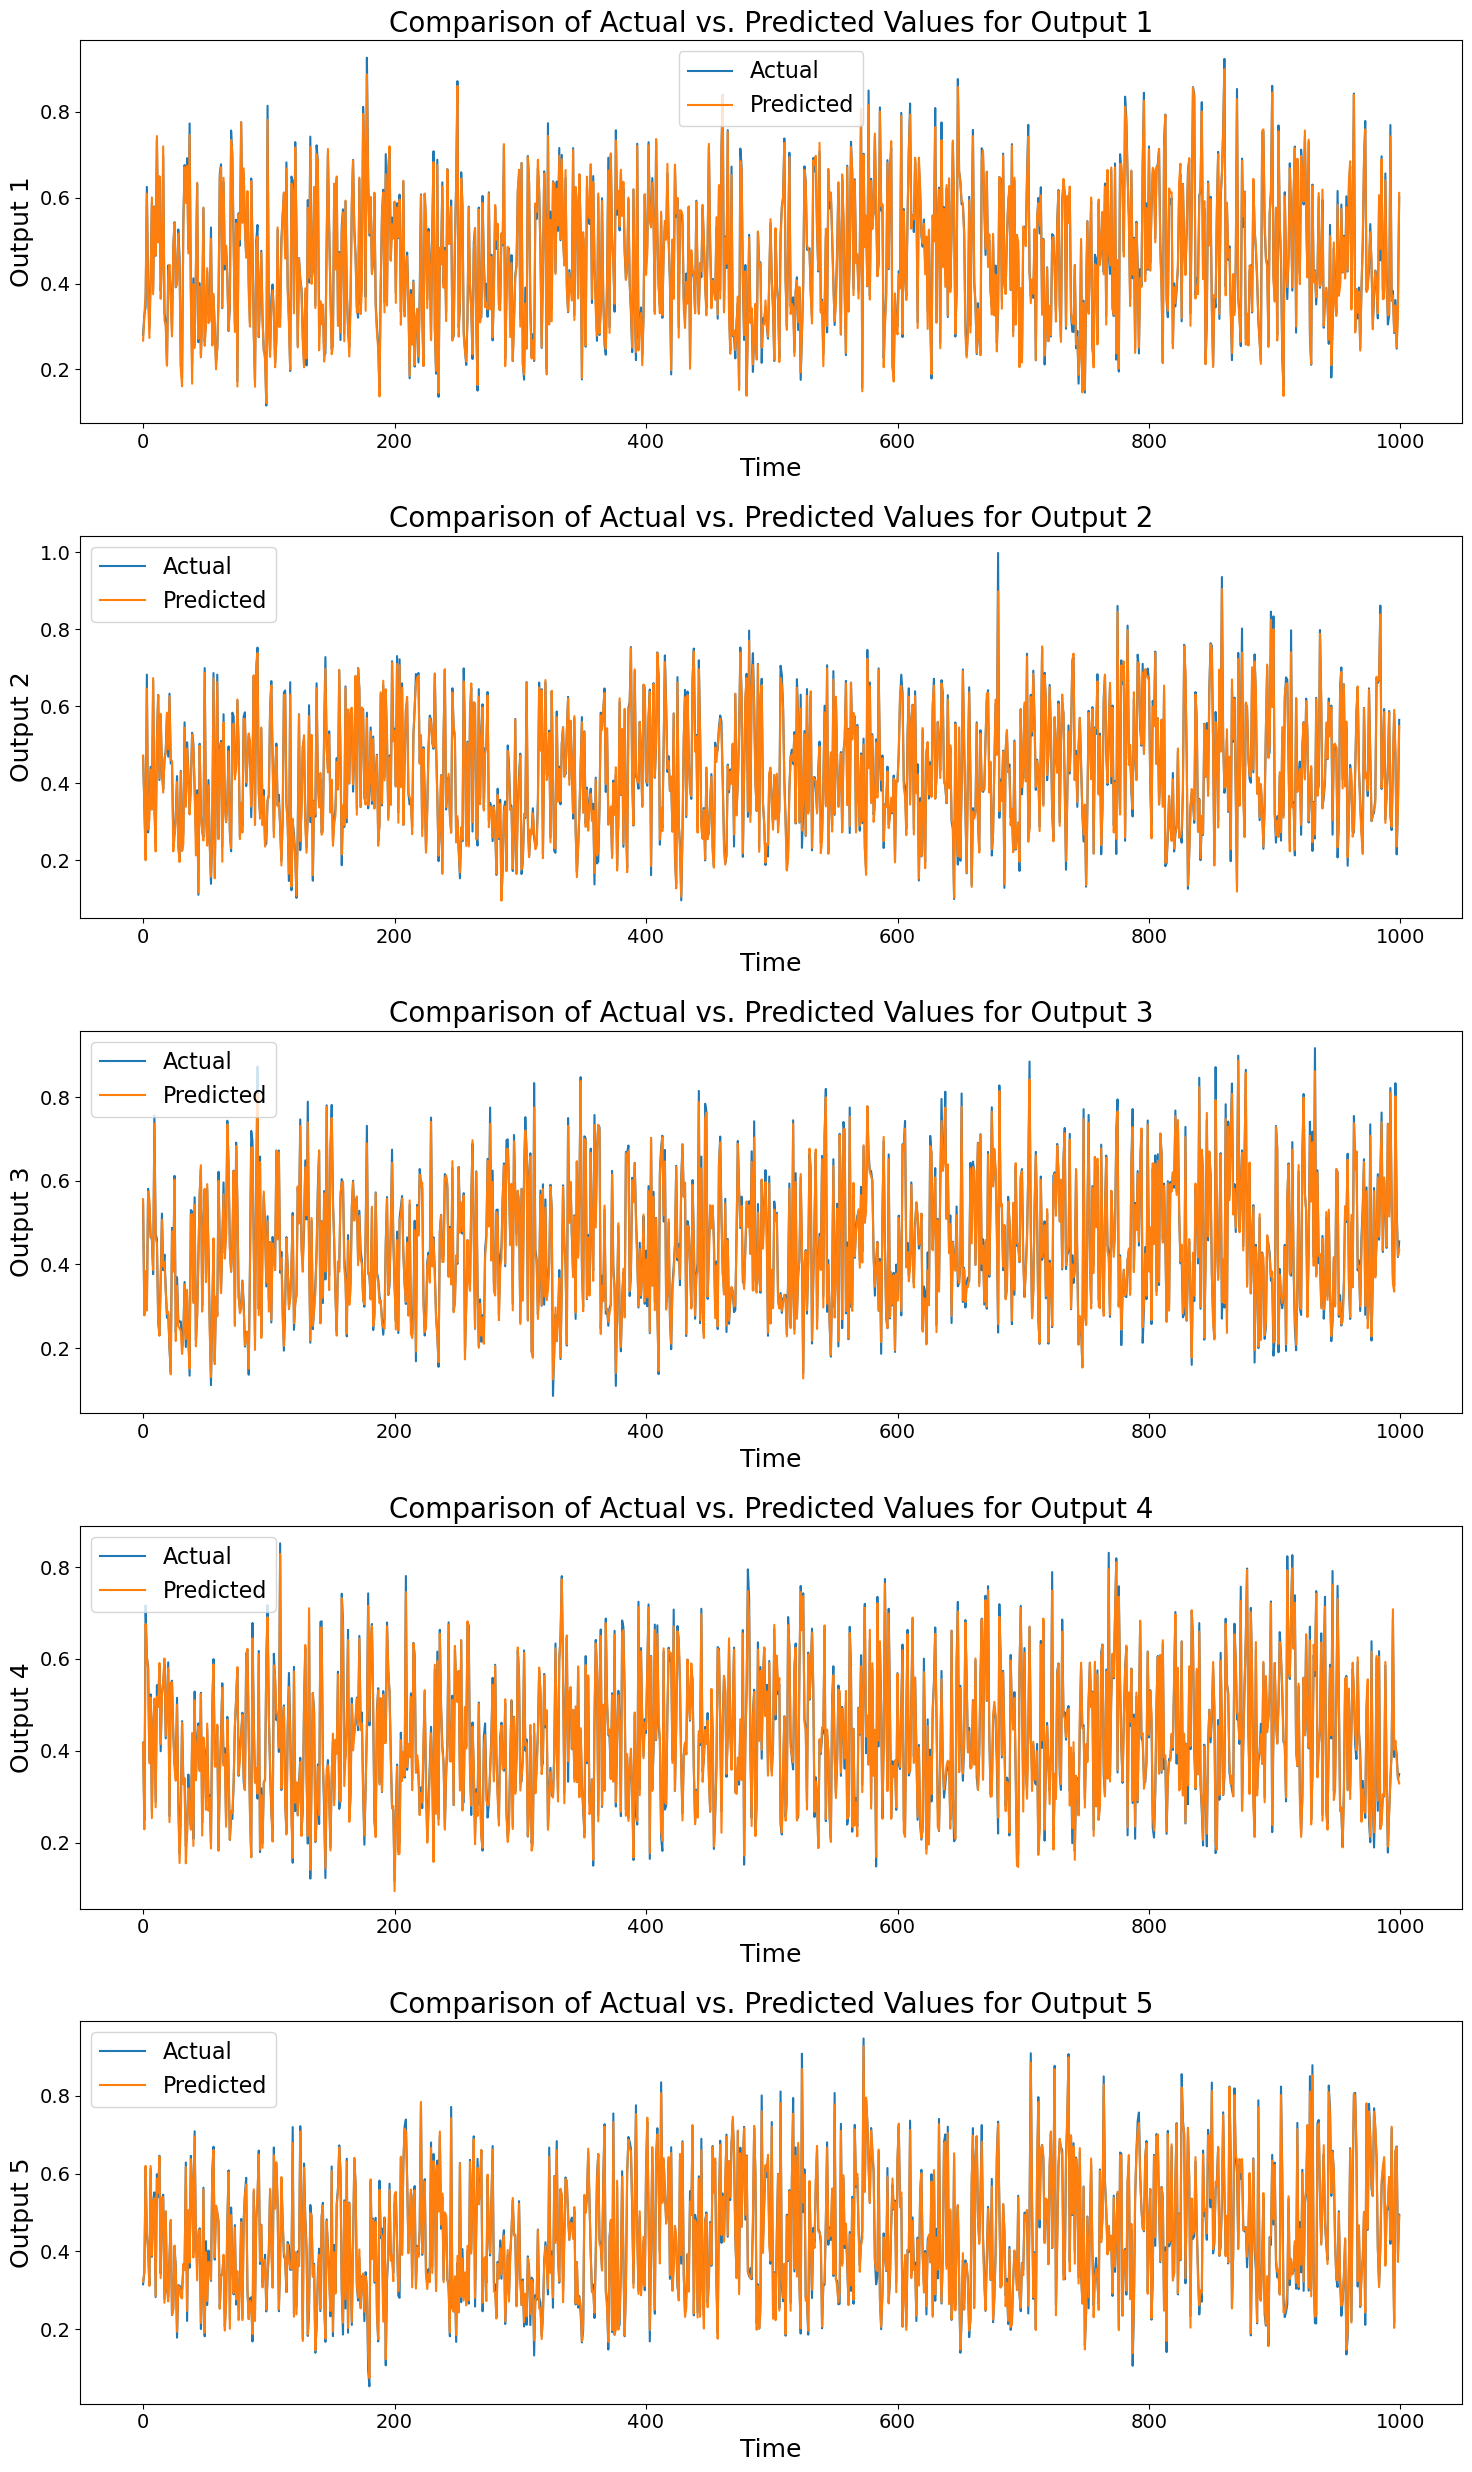

In [12]:
# 记录开始时间
start_time = time.time()

# 模型实例化和训练
input_dim_0 = x_0_train.shape[2]
input_dim_1 = x_1_train.shape[1]
hidden_dim = 64  # 可根据需要调整
output_dim = y_train.shape[1]
mlp_dim = 128 # 可根据需要调整

model_Transformer = TransformerModel(input_dim_0, input_dim_1, hidden_dim, 
                                     output_dim, SEQ_LENGTH, mlp_dim=mlp_dim).to(device)
criterion = nn.MSELoss()
model_Transformer = train_model(model_Transformer, train_loader, val_loader, criterion, 
                                save_dir=save_dir)

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"\n训练 TransformerModel 模型总时间: {hours}时{minutes}分{seconds}秒")
print("")
print("-" * 88)


# 创建测试指标 (与GRU部分相同)
mape_metric = MeanAbsolutePercentageError().to(device)
mae_metric = MeanAbsoluteError().to(device)

print("注意：torchmetrics 中的 MeanAbsolutePercentageError 方法并没有乘以 100！")

# 测试 - 直接使用测试张量
model_Transformer.eval()
with torch.no_grad():
    test_outputs = model_Transformer((x_0_test, x_1_test))
    test_loss = criterion(test_outputs, y_test)

    # 更新指标
    mape_metric.update(test_outputs, y_test)
    mae_metric.update(test_outputs, y_test)

mae = mae_metric.compute()
mape = mape_metric.compute() 

# 计算 MAE 占 y_test 均值的百分比
y_test_mean = y_test.mean()
mae_percentage = (mae / y_test_mean) * 100

print(f"\n测试损失: {test_loss:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")  # 乘以100，并添加百分号
print(f"MAE 占 y_test 平均值的百分比: {mae_percentage:.2f}%")  # 文字更清晰

# 绘图对比预测值和实际值 (与GRU部分相同)
num_outputs = y_test.shape[1]  # 输出维度，即水质指标的数量
timesteps = y_test.shape[0] # 时间步，即行数

plt.figure(figsize=(15, 5 * num_outputs)) # 根据指标数量调整图像大小

# 设置全局字体大小
plt.rcParams.update({'font.size': 16})  # 将字体大小设置为 16

for i in range(num_outputs):
    plt.subplot(num_outputs, 1, i + 1)  # 创建子图
    plt.plot(range(timesteps), y_test[:, i].cpu().numpy(), label="Actual")  # 绘制实际值
    plt.plot(range(timesteps), test_outputs[:, i].cpu().numpy(), label="Predicted")  # 绘制预测值
    plt.xlabel("Time", fontsize=18) # 增大 x 轴标签字体大小
    plt.ylabel(f"Output {i+1}", fontsize=18)  # 增大 y 轴标签字体大小
    plt.title(f"Comparison of Actual vs. Predicted Values for Output {i+1}", fontsize=20) 
    plt.legend(fontsize=16)  # 增大图例字体大小
    plt.xticks(fontsize=14) # 增大 x 轴刻度字体大小
    plt.yticks(fontsize=14) # 增大 y 轴刻度字体大小

plt.tight_layout()  # 调整子图布局
plt.show()

### 优化超参数

利用 Optuna 算法库对模型的超参数进行贝叶斯优化。

贝叶斯优化是一种基于贝叶斯定理的全局优化方法，它通过迭代地构建目标函数的概率模型，并利用该模型来指导下一步的采样，从而高效地寻找最优参数。Optuna 则是一个自动化超参数优化框架，它实现了多种贝叶斯优化算法（例如TPE），并提供了友好的API，方便用户对机器学习模型进行参数调优。

#### Transformer模型

**设置用时（秒）：**

In [13]:
timeout_seconds = 3600 * 60

**进行耗时的贝叶斯优化，寻找最优参数：**

In [14]:
# def objective(trial):
#     """
#     Optuna 的目标函数，用于优化 Transformer 模型的超参数。

#     Args:
#         trial: Optuna 的 trial 对象。

#     Returns:
#         float: 验证集上的 MAPE 值。
#     """

#     # 超参数搜索空间：训练参数
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
#     lr_decay_factor = trial.suggest_float("lr_decay_factor", 0.1, 0.9)
#     max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)

#     # 超参数搜索空间：深度学习模型结构参数
#     seq_len = trial.suggest_int("seq_len", 6, 24)  # 根据实际情况调整范围
#     hidden_dim = trial.suggest_categorical("hidden_dim", [2**i for i in range(5, 9)]) # 2**k
#     # 确保 nhead 可以整除 hidden_dim
#     nhead_options = [i for i in range(2, 9, 2) if hidden_dim % i == 0]
#     nhead = trial.suggest_categorical("nhead", nhead_options)
#     nlayers = trial.suggest_int("nlayers", 1, 4)
#     embedding_dropout = trial.suggest_float("embedding_dropout", 0.0, 0.5)
#     dim_feedforward = trial.suggest_int("dim_feedforward", 128, 1024)
#     transformer_dropout = trial.suggest_float("transformer_dropout", 0.0, 0.5)
#     activation = F.relu # 固定激活函数为ReLU，如果优化它，需谨慎
#     norm_first = trial.suggest_categorical("norm_first", [True, False])
#     transformer_bias = trial.suggest_categorical("transformer_bias", [True, False])
#     mlp_dropout = trial.suggest_float("mlp_dropout", 0.0, 0.5)
#     mlp_dim = trial.suggest_int("mlp_dim", hidden_dim, hidden_dim * 2)  # 与 hidden_dim 相关


#     # 创建序列
#     x_0, x_1, y, n_samples = create_sequences(df_scaled, seq_length=seq_len)

#     # 生成深度学习训练、验证数据
#     train_cutoff_seq = train_cutoff - seq_len
#     val_cutoff_seq = val_cutoff - seq_len

#     x_0_train = x_0[:train_cutoff_seq]
#     x_1_train = x_1[:train_cutoff_seq]
#     y_train = y[:train_cutoff_seq]

#     x_0_val = x_0[train_cutoff_seq:val_cutoff_seq]
#     x_1_val = x_1[train_cutoff_seq:val_cutoff_seq]
#     y_val = y[train_cutoff_seq:val_cutoff_seq]

#     # 将 numpy 数组转换为 PyTorch 张量，并移动到设备
#     x_0_train = torch.tensor(x_0_train, dtype=torch.float32).to(device)
#     x_1_train = torch.tensor(x_1_train, dtype=torch.float32).to(device)
#     y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

#     x_0_val = torch.tensor(x_0_val, dtype=torch.float32).to(device)
#     x_1_val = torch.tensor(x_1_val, dtype=torch.float32).to(device)
#     y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

#     # 创建 DataLoader
#     train_dataset = torch.utils.data.TensorDataset(x_0_train, x_1_train, y_train)
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     val_dataset = torch.utils.data.TensorDataset(x_0_val, x_1_val, y_val)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    

#     # 模型实例化和训练 (使用所有超参数)
#     input_dim_0 = x_0_train.shape[2]
#     input_dim_1 = x_1_train.shape[1]
#     output_dim = y_train.shape[1]

#     model = TransformerModel(input_dim_0, input_dim_1, hidden_dim, output_dim, seq_len,
#                             nhead=nhead, nlayers=nlayers, embedding_dropout=embedding_dropout,
#                             dim_feedforward=dim_feedforward, 
#                             transformer_dropout=transformer_dropout,
#                             activation=activation, norm_first=norm_first, 
#                             transformer_bias=transformer_bias,
#                             mlp_dropout=mlp_dropout, mlp_dim=mlp_dim).to(device)

#     criterion = nn.MSELoss()

#     model = train_model(model, train_loader, val_loader, criterion,
#                         lr_decay_factor=lr_decay_factor, max_grad_norm=max_grad_norm,
#                         save_dir=save_dir)

#     # 验证集评估
#     mape_metric = MeanAbsolutePercentageError().to(device)
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model((x_0_val, x_1_val))
#         mape_metric.update(val_outputs, y_val)
#     mape = mape_metric.compute()

#     return mape


# # Optuna 研究设置
# study = optuna.create_study(direction="minimize")  # 最小化 MAPE
# study.optimize(objective, timeout=timeout_seconds)  # 设置超时时间

# # 输出最佳超参数和 MAPE 值
# print("Best hyperparameters:", study.best_params)
# print("Best MAPE:", study.best_value) 

**优化结果：**

Best hyperparameters: {'batch_size': 16, 'lr_decay_factor': 0.8115564909926002, 'max_grad_norm': 1.4419811968083052, 'seq_len': 24, 'hidden_dim': 256, 'nhead': 8, 'nlayers': 2, 'embedding_dropout': 0.11715800587854795, 'dim_feedforward': 428, 'transformer_dropout': 0.24713122431473905, 'norm_first': False, 'transformer_bias': True, 'mlp_dropout': 2.337273201605261e-05, 'mlp_dim': 433}

Best MAPE: 0.015272049233317375

**根据最优超参数训练测试模型：**

Number of deep learning samples available: 9976
Number of rows in original DataFrame: 10000

--- Training Data ---
x_0_train shape: (7976, 24, 17)
x_1_train shape: (7976, 12)
y_train shape: (7976, 5)

--- Validation Data ---
x_0_val shape: (1000, 24, 17)
x_1_val shape: (1000, 12)
y_val shape: (1000, 5)

--- Test Data ---
x_0_test shape: (1000, 24, 17)
x_1_test shape: (1000, 12)
y_test shape: (1000, 5)
----------------------------------------------------------------------------------------
Epoch 1/100, Train Loss: 0.0190, Validation Loss: 0.0056
Epoch 2/100, Train Loss: 0.0034, Validation Loss: 0.0021
Epoch 3/100, Train Loss: 0.0015, Validation Loss: 0.0013
Epoch 4/100, Train Loss: 0.0012, Validation Loss: 0.0011
Epoch 5/100, Train Loss: 0.0009, Validation Loss: 0.0006
Epoch 6/100, Train Loss: 0.0006, Validation Loss: 0.0006
Epoch 7/100, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 8/100, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 9/100, Train Loss: 0.0002, Validation Loss: 

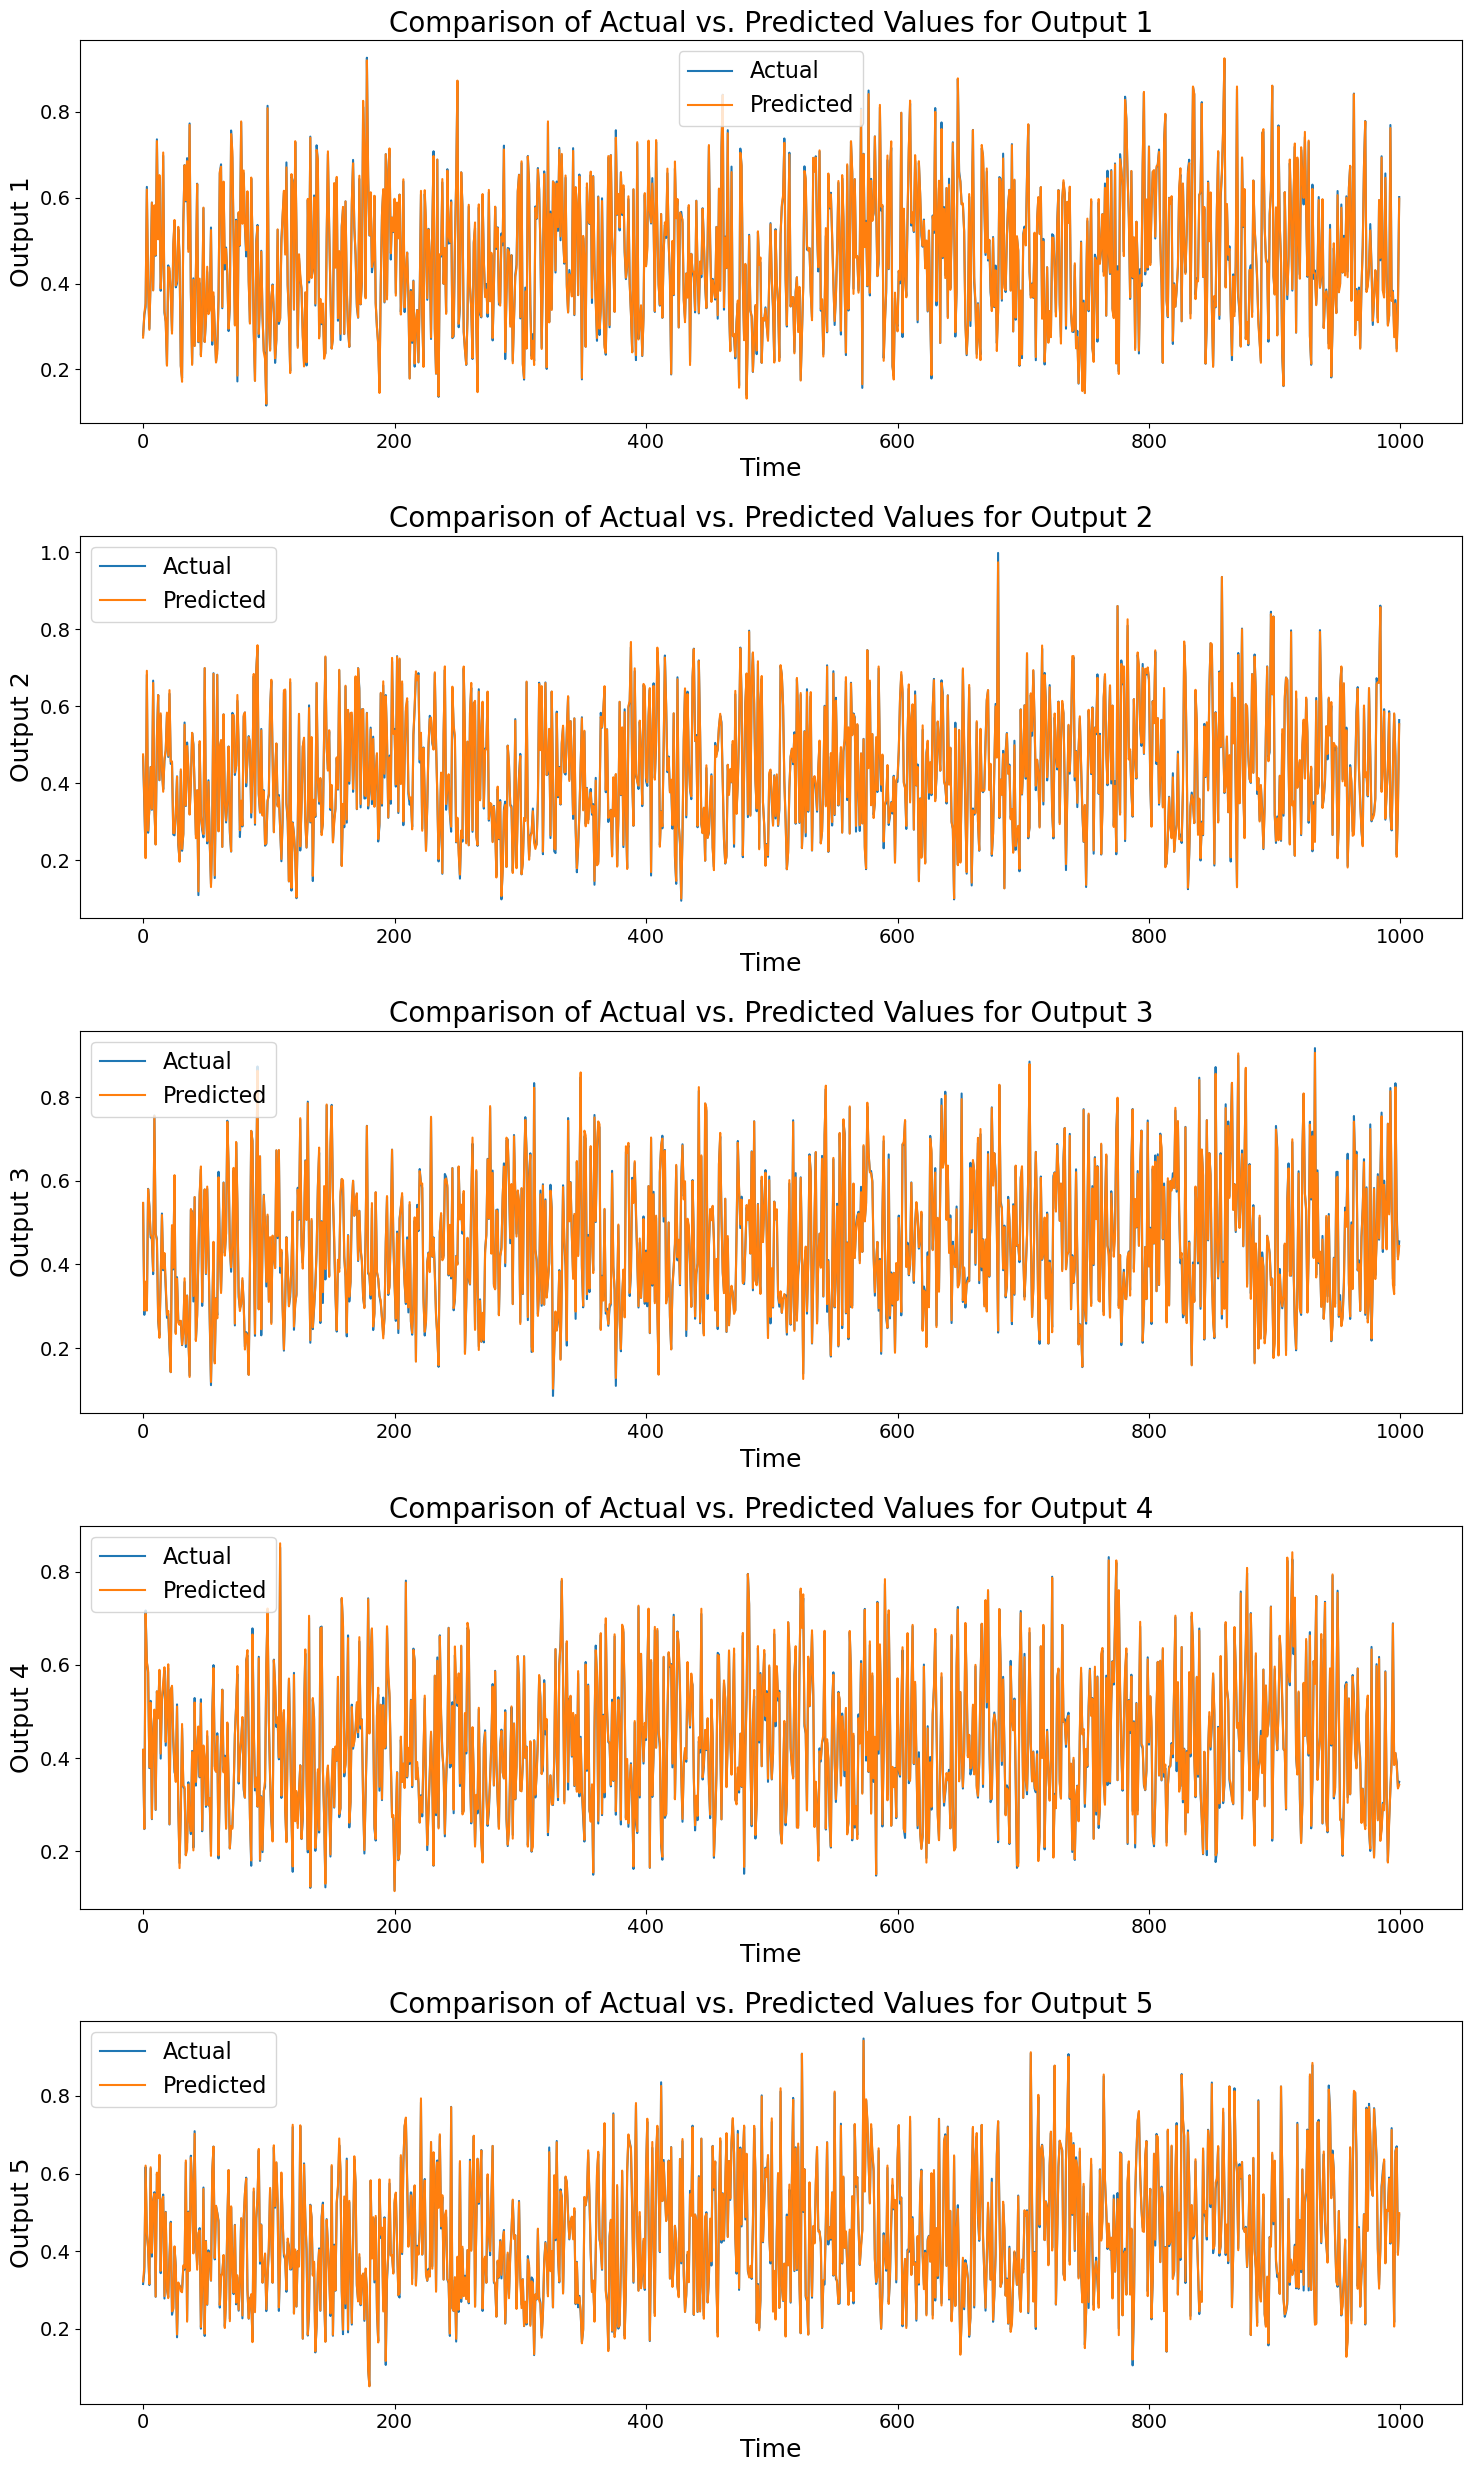

In [15]:
# 如果刚运行过费时的超参数优化，请使用下面这行代码
# Param_Dict_Transformer = study.best_params

# 如果知道最优超参数，请使用下面这行代码
Param_Dict_Transformer = {
    'batch_size': 16,
    'lr_decay_factor': 0.8115564909926002,
    'max_grad_norm': 1.4419811968083052,
    'seq_len': 24,
    'hidden_dim': 256,
    'nhead': 8,
    'nlayers': 2,
    'embedding_dropout': 0.11715800587854795,
    'dim_feedforward': 428,
    'transformer_dropout': 0.24713122431473905,
    'norm_first': False,
    'transformer_bias': True,
    'mlp_dropout': 2.337273201605261e-05,
    'mlp_dim': 433
}

# 深度学习的训练超参数
batch_size = Param_Dict_Transformer['batch_size']
lr_decay_factor = Param_Dict_Transformer['lr_decay_factor']
max_grad_norm = Param_Dict_Transformer['max_grad_norm']

# 深度学习的结构超参数
Param_Dict_Transformer_Struct = {
    key: value
    for key, value in Param_Dict_Transformer.items()
    if key not in ["batch_size", "lr_decay_factor", "max_grad_norm"]
}


# 过去变量长度
seq_len = Param_Dict_Transformer_Struct['seq_len']

# 创建序列
x_0, x_1, y, n_samples = create_sequences(df_scaled, seq_length=seq_len)

# 生成深度学习训练、验证数据
train_cutoff_seq = train_cutoff - seq_len
val_cutoff_seq = val_cutoff - seq_len

x_0_train = x_0[:train_cutoff_seq]
x_1_train = x_1[:train_cutoff_seq]
y_train = y[:train_cutoff_seq]

x_0_val = x_0[train_cutoff_seq:val_cutoff_seq]
x_1_val = x_1[train_cutoff_seq:val_cutoff_seq]
y_val = y[train_cutoff_seq:val_cutoff_seq]

x_0_test = x_0[val_cutoff_seq:]
x_1_test = x_1[val_cutoff_seq:]
y_test = y[val_cutoff_seq:]

# 打印信息
print(f"Number of deep learning samples available: {n_samples}")
print(f"Number of rows in original DataFrame: {len(df)}")

print("\n--- Training Data ---")
print(f"x_0_train shape: {x_0_train.shape}")
print(f"x_1_train shape: {x_1_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Validation Data ---")
print(f"x_0_val shape: {x_0_val.shape}")
print(f"x_1_val shape: {x_1_val.shape}")
print(f"y_val shape: {y_val.shape}")

print("\n--- Test Data ---")
print(f"x_0_test shape: {x_0_test.shape}")
print(f"x_1_test shape: {x_1_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("-" * 88)

# 数据加载和预处理
batch_size = batch_size

# 将 numpy 数组转换为 PyTorch 张量，并移动到设备
x_0_train = torch.tensor(x_0_train, dtype=torch.float32).to(device)
x_1_train = torch.tensor(x_1_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

x_0_val = torch.tensor(x_0_val, dtype=torch.float32).to(device)
x_1_val = torch.tensor(x_1_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

x_0_test = torch.tensor(x_0_test, dtype=torch.float32).to(device)
x_1_test = torch.tensor(x_1_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# 创建 DataLoader
train_dataset = torch.utils.data.TensorDataset(x_0_train, x_1_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_0_val, x_1_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_0_test, x_1_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 模型实例化和训练 (使用所有超参数)
input_dim_0 = x_0_train.shape[2]
input_dim_1 = x_1_train.shape[1]
output_dim = y_train.shape[1]

model_Transformer_Tuned = TransformerModel(
    input_dim_0 = input_dim_0,
    input_dim_1 = input_dim_1,
    output_dim = output_dim,
    **Param_Dict_Transformer_Struct,
).to(device)

criterion = nn.MSELoss()

model_Transformer_Tuned = train_model(
    model_Transformer_Tuned,
    train_loader,
    val_loader,
    criterion,
    lr_decay_factor=lr_decay_factor,
    max_grad_norm=max_grad_norm,
    save_dir=save_dir,
)

# 创建测试指标 (与GRU部分相同)
mape_metric = MeanAbsolutePercentageError().to(device)
mae_metric = MeanAbsoluteError().to(device)

print("注意：torchmetrics 中的 MeanAbsolutePercentageError 方法并没有乘以 100！")

# 测试 - 直接使用测试张量
model_Transformer_Tuned.eval()
with torch.no_grad():
    test_outputs = model_Transformer_Tuned((x_0_test, x_1_test))
    test_loss = criterion(test_outputs, y_test)

    # 更新指标
    mape_metric.update(test_outputs, y_test)
    mae_metric.update(test_outputs, y_test)

mae = mae_metric.compute()
mape = mape_metric.compute() 

# 计算 MAE 占 y_test 均值的百分比
y_test_mean = y_test.mean()
mae_percentage = (mae / y_test_mean) * 100

print(f"\n测试损失: {test_loss:.4f}")
print(f"平均绝对误差 (MAE): {mae:.4f}")
print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")  # 乘以100，并添加百分号
print(f"MAE 占 y_test 平均值的百分比: {mae_percentage:.2f}%")  # 文字更清晰

# 绘图对比预测值和实际值 (与GRU部分相同)
num_outputs = y_test.shape[1]  # 输出维度，即水质指标的数量
timesteps = y_test.shape[0] # 时间步，即行数

plt.figure(figsize=(15, 5 * num_outputs)) # 根据指标数量调整图像大小

# 设置全局字体大小
plt.rcParams.update({'font.size': 16})  # 将字体大小设置为 16

for i in range(num_outputs):
    plt.subplot(num_outputs, 1, i + 1)  # 创建子图
    plt.plot(range(timesteps), y_test[:, i].cpu().numpy(), label="Actual")  # 绘制实际值
    plt.plot(range(timesteps), test_outputs[:, i].cpu().numpy(), label="Predicted")  # 绘制预测值
    plt.xlabel("Time", fontsize=18) # 增大 x 轴标签字体大小
    plt.ylabel(f"Output {i+1}", fontsize=18)  # 增大 y 轴标签字体大小
    plt.title(f"Comparison of Actual vs. Predicted Values for Output {i+1}", fontsize=20) 
    plt.legend(fontsize=16)  # 增大图例字体大小
    plt.xticks(fontsize=14) # 增大 x 轴刻度字体大小
    plt.yticks(fontsize=14) # 增大 y 轴刻度字体大小

plt.tight_layout()  # 调整子图布局
plt.show()

## 工艺模拟器

工艺模拟器需要嵌入之前训练好的深度学习模型，然后在每个时间步长给出进水水质和药剂投加量，模拟器会结合对过去一段时间水质与药剂投加的记忆，得出这个时间步长的出水水质。这就好像是给定外界干预（进水水质和药剂投加量），就产生复杂工艺流程的输出结果（出水水质）。

**注意：在模拟器不断运行的过程中，除了开始的若干步，模拟器对过去记忆中出水水质的部分都是由它自己生成的。所以，一旦模拟器开始运行，就不需要出水水质数据，只需要外界干预。从这点看，它完全复刻了现实的运作方式。**

### 定义模拟器

#### 基于GRU

In [16]:
class WaterTreatmentSimulator_GRU:
    def __init__(self, engine, preprocessor, seq_len, past_data_tensor, day_hour_tensor=None):
        """
        初始化水处理工艺模拟器。

        Args:
            engine (GRUModel): 已经定义且训练好的GRUModel实例。
            preprocessor: DataPreprocessor类实例，作为预处理器。
            seq_len (int): 过去序列的长度。
            past_data_tensor (torch.Tensor): 形状为[seq_len_upper, input_dim_0-2]的张量，
            每一行各元素依次代表过去的进水水质、药剂投加和出水水质。
            day_hour_tensor (torch.Tensor, optional): 长度为2的张量，代表当下的“Day”和“Hour”。
        """
        # input_dim_0: 所有变量数：时间变量数 + 进水水质变量数 + 投加药剂变量数 + 出水水质的变量数
        # input_dim_1: 时间变量数 + 进水水质变量数 + 投加药剂变量数
        # output_dim: 出水水质的变量数
        self.engine = engine.to("cpu")
        self.preprocessor = preprocessor
        self.seq_len = seq_len
        self.input_dim_0 = engine.gru.input_size
        self.input_dim_1 = engine.mlp[0].in_features - engine.gru.hidden_size
        self.output_dim = engine.mlp[-1].out_features
        self.hidden_dim = engine.gru.hidden_size

        # 当下的时间，如果没有提供，默认初始化为 Day=1, Hour=0
        if day_hour_tensor is None:
            day_hour_tensor = torch.tensor([1, 0], dtype=torch.float32)
        self.current_time = day_hour_tensor

        # 取过去seq_len步的数据，得到[seq_len, input_dim_0 - 2]的张量
        assert past_data_tensor.shape[0] >= seq_len, "past_data_tensor 的长度必须至少为 seq_len"
        past_data_seq = past_data_tensor[-seq_len:, :]

        # 生成时间张量 [seq_len, 2]
        past_time_seq = []
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        for _ in range(seq_len):
            hour -= 1
            if hour < 0:
                hour = 23
                day -= 1
            if day < 1:
                day = 365
            past_time_seq.append([day, hour])
        past_time_seq = torch.tensor(past_time_seq[::-1], dtype=torch.float32)  # 倒序排列

        # 合并时间与水质数据，得到 [seq_len, input_dim_0]
        past_combined_seq = torch.cat((past_time_seq, past_data_seq), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        past_combined_seq_np = past_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            past_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 0] / 365)  # 转换 Day
            past_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器进行归一化，得到对过去的记忆的tensor
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            past_combined_seq_scaled = self.preprocessor.scaler.transform(past_combined_seq_np)
            
        self.memory = torch.tensor(past_combined_seq_scaled, dtype=torch.float32)

    def simulate_dosage(self, future_data_tensor):
        """
        模拟投加药剂的过程。

        Args:
            future_data_tensor (torch.Tensor): 形状为[L, input_dim_1-2]的张量，
            代表当下及未来L步的进水水质和药剂投加。

        Returns:
            torch.Tensor: 形状为[L, output_dim]的张量，代表当下及未来的出水水质。
        """
        future_data_tensor = future_data_tensor.to("cpu")
        
        L = future_data_tensor.shape[0]
        future_output = torch.zeros((L, self.output_dim), dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])

        # 生成未来时间张量 [L, 2]
        future_time_seq = []
        for _ in range(L):
            future_time_seq.append([day, hour])
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
        future_time_seq = torch.tensor(future_time_seq, dtype=torch.float32)

        # 合并时间与未来水质数据，得到 [L, input_dim_1]
        future_combined_seq = torch.cat((future_time_seq, future_data_tensor), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        future_combined_seq_np = future_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            future_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 0] / 365)  # 转换 Day
            future_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器的scaler_other进行归一化
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            future_combined_seq_scaled = self.preprocessor.scaler_other.transform(
                future_combined_seq_np)
        future_combined_seq = torch.tensor(future_combined_seq_scaled, dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        
        # 遍历未来的每一行，使用模型进行预测
        for i in range(L):
            current_input = future_combined_seq[i].unsqueeze(0)  # [1, input_dim_1]
            model_input = (self.memory.unsqueeze(0), current_input)
            with torch.no_grad():
                output = self.engine(model_input).squeeze(0)  # [output_dim]
            future_output[i] = output

            # 更新记忆：删除最早的一行，添加最新的一行
            new_memory_row = torch.cat((current_input.squeeze(0), output), dim=0).unsqueeze(0)
            self.memory = torch.cat((self.memory[1:], new_memory_row), dim=0)

            # 更新当前时间
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
            self.current_time = torch.tensor([day, hour], dtype=torch.float32)

        # 使用预处理器的scaler_effluent进行逆变换
        future_output_np = future_output.numpy()
        future_output_inversed = self.preprocessor.scaler_effluent.inverse_transform(
            future_output_np)
        future_output = torch.tensor(future_output_inversed, dtype=torch.float32)

        return future_output

#### 基于LSTM

In [17]:
class WaterTreatmentSimulator_LSTM:
    def __init__(self, engine, preprocessor, seq_len, past_data_tensor, day_hour_tensor=None):
        """
        初始化水处理工艺模拟器，基于 LSTMModel。

        Args:
            engine (LSTMModel): 已经定义且训练好的 LSTMModel 实例。
            preprocessor: DataPreprocessor 类实例，作为预处理器。
            seq_len (int): 过去序列的长度。
            past_data_tensor (torch.Tensor): 形状为 [seq_len_upper, input_dim_0 - 2] 的张量，
                每一行各元素依次代表过去的进水水质、药剂投加和出水水质。
            day_hour_tensor (torch.Tensor, optional): 长度为 2 的张量，代表当下的“Day”和“Hour”。
        """
        # input_dim_0: 所有变量数：时间变量数 + 进水水质变量数 + 投加药剂变量数 + 出水水质的变量数
        # input_dim_1: 时间变量数 + 进水水质变量数 + 投加药剂变量数
        # output_dim: 出水水质的变量数
        self.engine = engine.to("cpu")
        self.preprocessor = preprocessor
        self.seq_len = seq_len
        
        self.input_dim_0 = engine.lstm.input_size  # LSTM 输入维度
        self.input_dim_1 = engine.mlp[0].in_features - engine.lstm.hidden_size  # 其他输入的维度
        self.output_dim = engine.mlp[-1].out_features
        self.hidden_dim = engine.lstm.hidden_size  # LSTM 隐藏层维度

        # 当下的时间，如果没有提供，默认初始化为 Day=1, Hour=0
        if day_hour_tensor is None:
            day_hour_tensor = torch.tensor([1, 0], dtype=torch.float32)
        self.current_time = day_hour_tensor

        # 取过去seq_len步的数据，得到[seq_len, input_dim_0 - 2]的张量
        assert past_data_tensor.shape[0] >= seq_len, "past_data_tensor 的长度必须至少为 seq_len"
        past_data_seq = past_data_tensor[-seq_len:, :]

        # 生成时间张量 [seq_len, 2]
        past_time_seq = []
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        for _ in range(seq_len):
            hour -= 1
            if hour < 0:
                hour = 23
                day -= 1
            if day < 1:
                day = 365
            past_time_seq.append([day, hour])
        past_time_seq = torch.tensor(past_time_seq[::-1], dtype=torch.float32)  # 倒序排列

        # 合并时间与水质数据，得到 [seq_len, input_dim_0]
        past_combined_seq = torch.cat((past_time_seq, past_data_seq), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        past_combined_seq_np = past_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            past_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 0] / 365)  # 转换 Day
            past_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器进行归一化，得到对过去的记忆的tensor
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            past_combined_seq_scaled = self.preprocessor.scaler.transform(past_combined_seq_np)
            
        self.memory = torch.tensor(past_combined_seq_scaled, dtype=torch.float32)

    def simulate_dosage(self, future_data_tensor):
        """
        模拟投加药剂的过程，基于 LSTMModel。

        Args:
            future_data_tensor (torch.Tensor): 形状为 [L, input_dim_1 - 2] 的张量，
                代表当下及未来 L 步的进水水质和药剂投加。

        Returns:
            torch.Tensor: 形状为 [L, output_dim] 的张量，代表当下及未来的出水水质。
        """
        future_data_tensor = future_data_tensor.to("cpu")
        
        L = future_data_tensor.shape[0]
        future_output = torch.zeros((L, self.output_dim), dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])

        # 生成未来时间张量 [L, 2]
        future_time_seq = []
        for _ in range(L):
            future_time_seq.append([day, hour])
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
        future_time_seq = torch.tensor(future_time_seq, dtype=torch.float32)

        # 合并时间与未来水质数据，得到 [L, input_dim_1]
        future_combined_seq = torch.cat((future_time_seq, future_data_tensor), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        future_combined_seq_np = future_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            future_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 0] / 365)  # 转换 Day
            future_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器的scaler_other进行归一化
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            future_combined_seq_scaled = self.preprocessor.scaler_other.transform(
                future_combined_seq_np)
        future_combined_seq = torch.tensor(future_combined_seq_scaled, dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        
        # 遍历未来的每一行，使用模型进行预测
        for i in range(L):
            current_input = future_combined_seq[i].unsqueeze(0)  # [1, input_dim_1]
            model_input = (self.memory.unsqueeze(0), current_input)
            with torch.no_grad():
                output = self.engine(model_input).squeeze(0)  # [output_dim]
            future_output[i] = output

            # 更新记忆：删除最早的一行，添加最新的一行
            new_memory_row = torch.cat((current_input.squeeze(0), output), dim=0).unsqueeze(0)
            self.memory = torch.cat((self.memory[1:], new_memory_row), dim=0)

            # 更新当前时间
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
            self.current_time = torch.tensor([day, hour], dtype=torch.float32)

        # 使用预处理器的scaler_effluent进行逆变换
        future_output_np = future_output.numpy()
        future_output_inversed = self.preprocessor.scaler_effluent.inverse_transform(
            future_output_np)
        future_output = torch.tensor(future_output_inversed, dtype=torch.float32)

        return future_output

#### 基于Transformer

In [18]:
class WaterTreatmentSimulator_Transformer:

    def __init__(self, engine, preprocessor, seq_len, past_data_tensor, day_hour_tensor=None):
        """
        初始化水处理工艺模拟器，基于 TransformerModel。

        Args:
            engine (TransformerModel): 已经定义且训练好的 TransformerModel 实例。
            preprocessor: DataPreprocessor 类实例，作为预处理器。
            seq_len (int): 过去序列的长度。
            past_data_tensor (torch.Tensor): 形状为 [seq_len_upper, input_dim_0 - 2] 的张量，
                每一行各元素依次代表过去的进水水质、药剂投加和出水水质。
            day_hour_tensor (torch.Tensor, optional): 长度为 2 的张量，代表当下的“Day”和“Hour”。
        """

        self.engine = engine.to("cpu")
        self.preprocessor = preprocessor
        self.seq_len = seq_len

        self.input_dim_0 = engine.linear_embedding.in_features  # Transformer 输入维度
        self.input_dim_1 = engine.mlp[0].in_features - engine.linear_embedding.out_features # 其他输入的维度
        self.output_dim = engine.mlp[-1].out_features
        self.hidden_dim = engine.linear_embedding.out_features # Transformer 隐藏层维度

        if day_hour_tensor is None:
            day_hour_tensor = torch.tensor([1, 0], dtype=torch.float32)
        self.current_time = day_hour_tensor

        # 取过去seq_len步的数据，得到[seq_len, input_dim_0 - 2]的张量
        assert past_data_tensor.shape[0] >= seq_len, "past_data_tensor 的长度必须至少为 seq_len"
        past_data_seq = past_data_tensor[-seq_len:, :]

        # 生成时间张量 [seq_len, 2]
        past_time_seq = []
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        for _ in range(seq_len):
            hour -= 1
            if hour < 0:
                hour = 23
                day -= 1
            if day < 1:
                day = 365
            past_time_seq.append([day, hour])
        past_time_seq = torch.tensor(past_time_seq[::-1], dtype=torch.float32)  # 倒序排列

        # 合并时间与水质数据，得到 [seq_len, input_dim_0]
        past_combined_seq = torch.cat((past_time_seq, past_data_seq), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        past_combined_seq_np = past_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            past_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 0] / 365)  # 转换 Day
            past_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * past_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器进行归一化，得到对过去的记忆的tensor
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            past_combined_seq_scaled = self.preprocessor.scaler.transform(past_combined_seq_np)

        self.memory = torch.tensor(past_combined_seq_scaled, dtype=torch.float32)

    def simulate_dosage(self, future_data_tensor):
        """
        模拟投加药剂的过程，基于 TransformerModel。

        Args:
            future_data_tensor (torch.Tensor): 形状为 [L, input_dim_1 - 2] 的张量，
                代表当下及未来 L 步的进水水质和药剂投加。

        Returns:
            torch.Tensor: 形状为 [L, output_dim] 的张量，代表当下及未来的出水水质。
        """
        future_data_tensor = future_data_tensor.to("cpu")
        
        L = future_data_tensor.shape[0]
        future_output = torch.zeros((L, self.output_dim), dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])

        # 生成未来时间张量 [L, 2]
        future_time_seq = []
        for _ in range(L):
            future_time_seq.append([day, hour])
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
        future_time_seq = torch.tensor(future_time_seq, dtype=torch.float32)

        # 合并时间与未来水质数据，得到 [L, input_dim_1]
        future_combined_seq = torch.cat((future_time_seq, future_data_tensor), dim=1)

        # 如果预处理器的cyclic_time为True，转换时间变量为周期变量
        future_combined_seq_np = future_combined_seq.numpy()
        if self.preprocessor.cyclic_time:
            future_combined_seq_np[:, 0] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 0] / 365)  # 转换 Day
            future_combined_seq_np[:, 1] = np.sin(
                2 * np.pi * future_combined_seq_np[:, 1] / 24)  # 转换 Hour

        # 使用预处理器的scaler_other进行归一化
        with warnings.catch_warnings(): # 防止由于归一化数组（而不是带列名称的数据框）产生警告
            warnings.simplefilter("ignore", category=UserWarning) 
            future_combined_seq_scaled = self.preprocessor.scaler_other.transform(
                future_combined_seq_np)
        future_combined_seq = torch.tensor(future_combined_seq_scaled, dtype=torch.float32)

        # 设置 day 和 hour 为当前时间
        day, hour = int(self.current_time[0]), int(self.current_time[1])
        
        # 遍历未来的每一行，使用模型进行预测
        for i in range(L):
            current_input = future_combined_seq[i].unsqueeze(0)  # [1, input_dim_1]
            model_input = (self.memory.unsqueeze(0), current_input)
            with torch.no_grad():
                output = self.engine(model_input).squeeze(0)  # [output_dim]
            future_output[i] = output

            # 更新记忆：删除最早的一行，添加最新的一行
            new_memory_row = torch.cat((current_input.squeeze(0), output), dim=0).unsqueeze(0)
            self.memory = torch.cat((self.memory[1:], new_memory_row), dim=0)

            # 更新当前时间
            hour += 1
            if hour >= 24:
                hour = 0
                day += 1
            if day > 365:
                day = 1
            self.current_time = torch.tensor([day, hour], dtype=torch.float32)

        # 使用预处理器的scaler_effluent进行逆变换
        future_output_np = future_output.numpy()
        future_output_inversed = self.preprocessor.scaler_effluent.inverse_transform(
            future_output_np)
        future_output = torch.tensor(future_output_inversed, dtype=torch.float32)

        return future_output

### 模拟药剂投加

#### GRU模拟器

**方法1：逐行模拟**

即逐个时间点进行模拟，可以用于强化学习，作为“环境模型”。

In [19]:
# 记录开始时间
start_time = time.time()

outputs_1 = []

# 获取当前时间（从原始的未经归一化的数据框中，得到测试集的第一个 Day 和 Hour）
current_time = torch.tensor(df.iloc[val_cutoff, :2].values, dtype=torch.float32)
print("模拟开始的时间（[Day, Hour]），作为模型的当前时间，并随着模拟的进行，自动往前推移:")
print(current_time)
# 获取过去100行数据作为 past_data_tensor，代表过去一段时间的进水水质、药剂投加量和出水水质
past_data_tensor = torch.tensor(df.iloc[val_cutoff - 100:val_cutoff, 2:].values, dtype=torch.float32)
print("\n过去一段时间的进水水质、药剂投加量和出水水质，用来提取模型的初始记忆：")
print(past_data_tensor)
print(f"此张量的形状：{past_data_tensor.shape}")
print("")

# 初始化模拟器
simulator_1 = WaterTreatmentSimulator_GRU(model_GRU, preprocessor, SEQ_LENGTH, past_data_tensor, current_time)

for i in range(len(test_df)): # len(test_df) 为测试时间长度
    current_influent_dosage_tensor = torch.tensor(
        df.iloc[val_cutoff + i, 2:simulator_1.input_dim_1].values, dtype=torch.float32
    ).unsqueeze(0) # 当前时间（行）的进水水质与药剂投加量（依次排列）
    # 模拟投加药剂！
    output = simulator_1.simulate_dosage(current_influent_dosage_tensor)
    # 记录投加药剂后的出水水质
    outputs_1.append(output.squeeze(0).numpy())
outputs_1 = np.array(outputs_1)

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"共模拟{len(test_df)}次药剂投加")
print(f"运行时间: {hours}时{minutes}分{seconds}秒")
print("")

模拟开始的时间（[Day, Hour]），作为模型的当前时间，并随着模拟的进行，自动往前推移:
tensor([11.,  0.])

过去一段时间的进水水质、药剂投加量和出水水质，用来提取模型的初始记忆：
tensor([[10.6130,  4.4732,  2.5104,  ...,  3.8639,  9.4513,  6.7686],
        [ 2.5693,  6.0374,  3.6156,  ...,  6.5255, 10.0954,  3.6149],
        [ 7.5634,  4.6130,  5.2153,  ...,  8.1664, 13.1381, 10.6257],
        ...,
        [ 9.2136,  9.7948,  6.7644,  ...,  9.1849, 16.4461,  4.3875],
        [ 8.7270,  0.0522,  5.1149,  ...,  9.2316,  9.1489,  4.6258],
        [-0.1341,  4.8507,  4.3875,  ...,  7.9384, 12.3887,  7.9469]])
此张量的形状：torch.Size([100, 15])

共模拟1000次药剂投加
运行时间: 0时0分1秒



**方法 2：批量模拟**

In [20]:
# 记录开始时间
start_time = time.time()

# 获取当前时间（从原始的未经归一化的数据框中，得到测试集的第一个 Day 和 Hour）
current_time = torch.tensor(df.iloc[val_cutoff, :2].values, dtype=torch.float32)
# 获取过去100行数据作为 past_data_tensor，代表过去一段时间的进水水质、药剂投加量和出水水质
past_data_tensor = torch.tensor(df.iloc[val_cutoff - 100:val_cutoff, 2:].values, dtype=torch.float32)

# 初始化模拟器
simulator_2 = WaterTreatmentSimulator_GRU(model_GRU, preprocessor, SEQ_LENGTH, past_data_tensor, current_time)

# 测试集上的进水水质与药剂投加量，每行代表一个时间点
future_influent_dosage_tensor = torch.tensor(
    df.iloc[val_cutoff:val_cutoff + len(test_df), 2:simulator_2.input_dim_1].values, dtype=torch.float32
)
# 模拟投加药剂！
outputs_2 = simulator_2.simulate_dosage(future_influent_dosage_tensor).numpy()

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"共模拟{len(test_df)}次药剂投加")
print(f"运行时间: {hours}时{minutes}分{seconds}秒")
print("")

共模拟1000次药剂投加
运行时间: 0时0分0秒



**比较结果：**

In [21]:
print(f"两种方法的结果是否相同: {np.allclose(outputs_1, outputs_2)}")
print("")

两种方法的结果是否相同: True



**画图展示：**

MAE: 0.2106
MAPE: 2.64%
MAE Percentage of Average True Effluent: 2.29%

真实出水水质与模拟器产出对比：


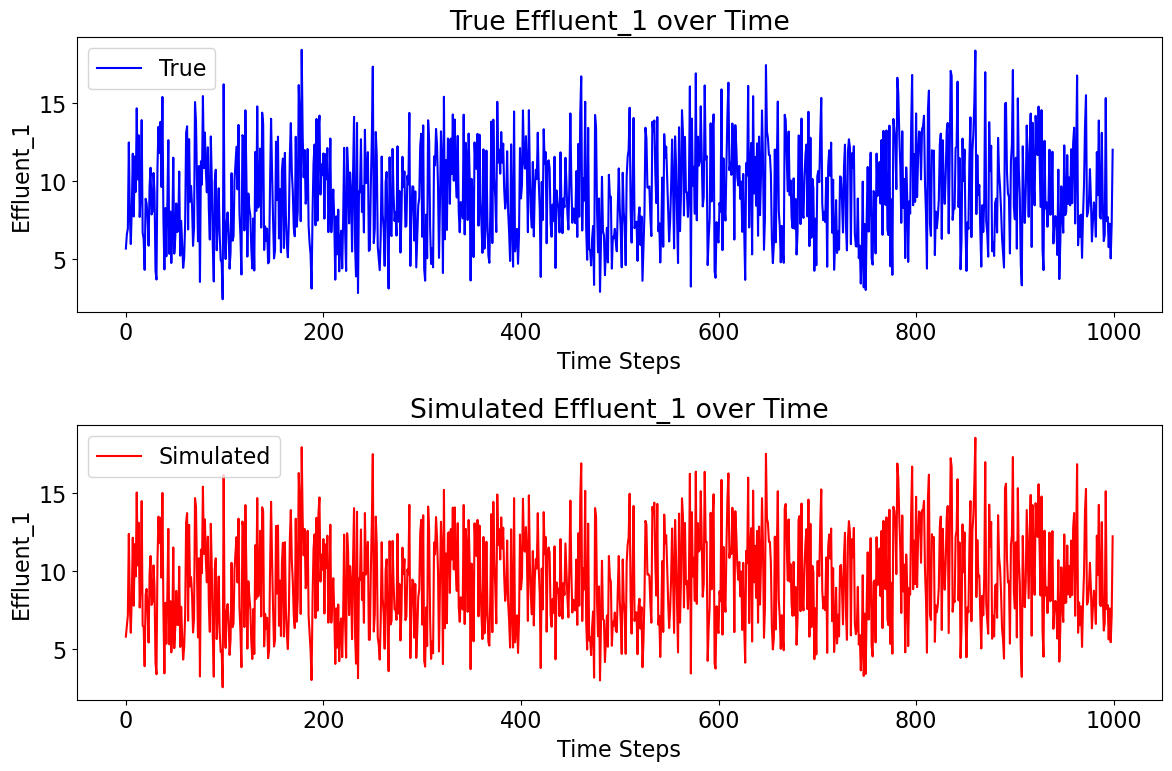

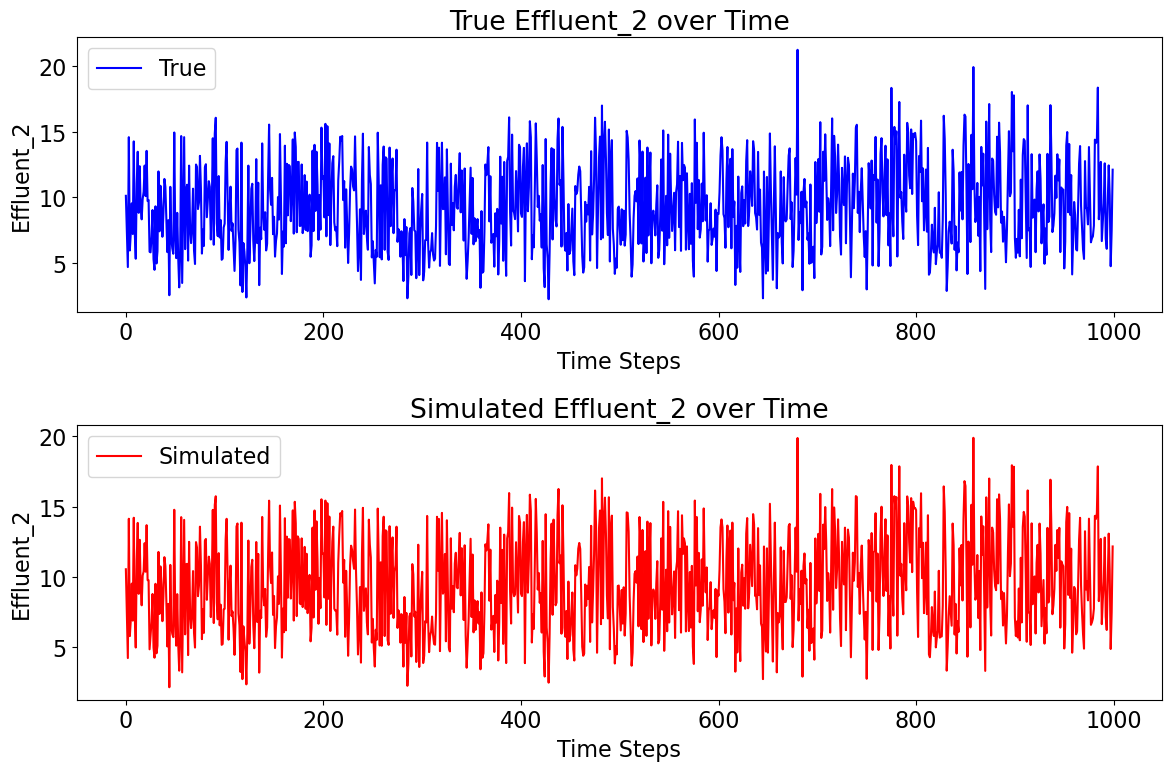

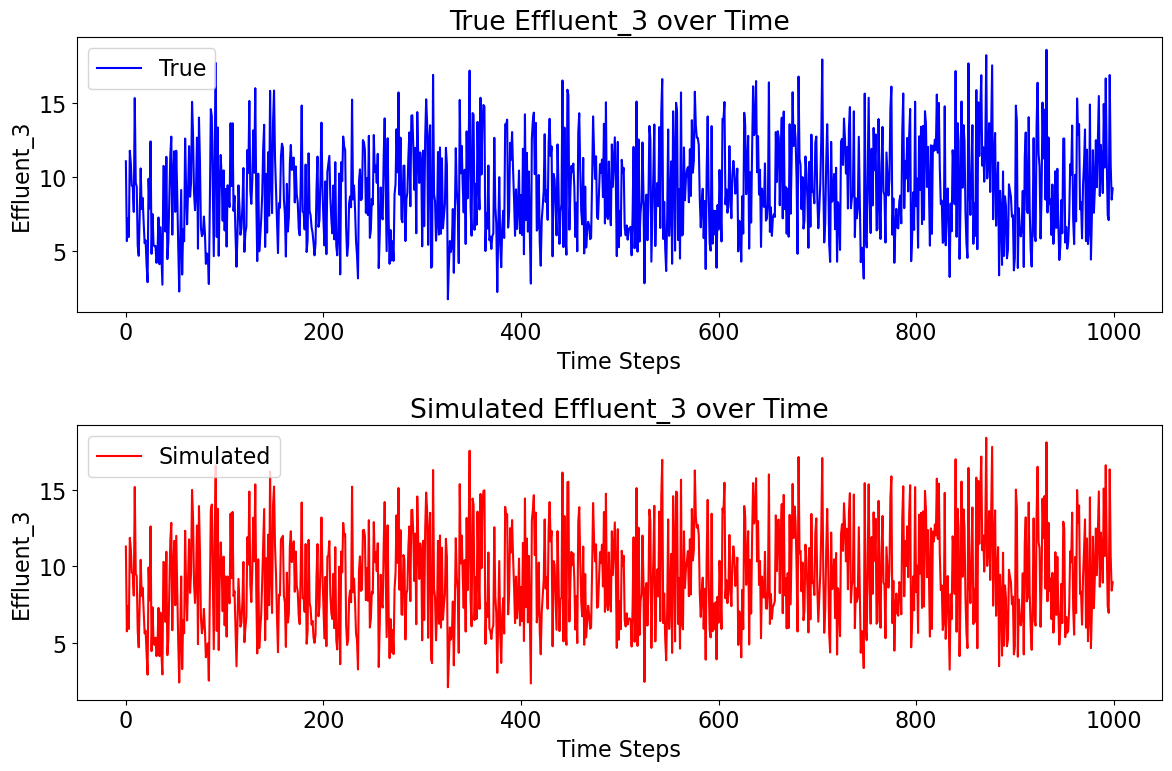

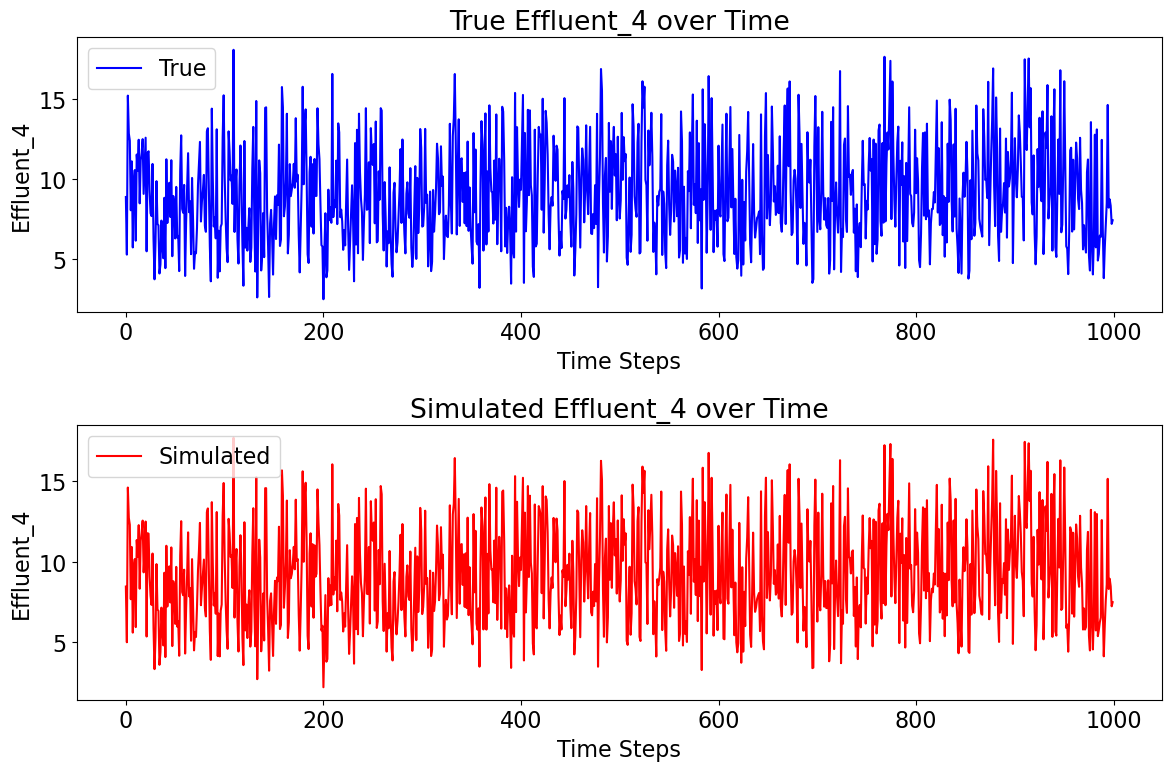

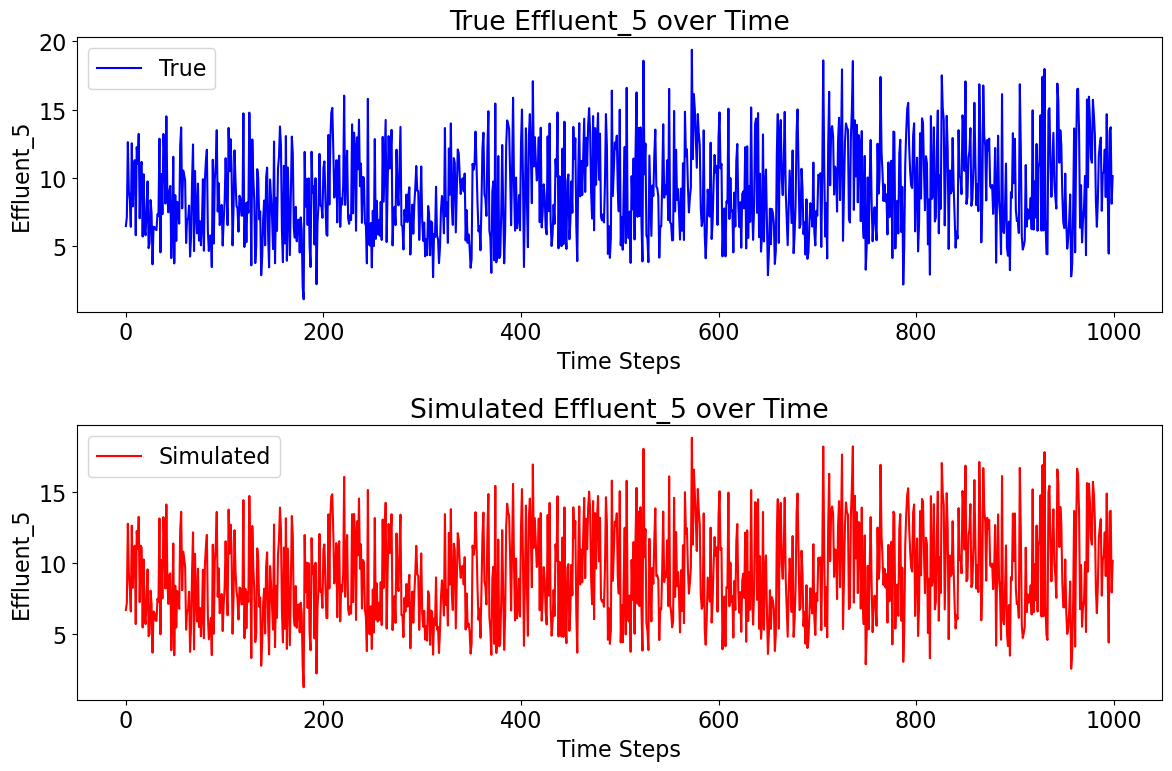

In [22]:
# 获取真实出水水质
effluent_cols = [col for col in df.columns if col.startswith("Effluent")]
true_effluent = df.loc[val_cutoff:, effluent_cols].values

# 计算指标
mae = mean_absolute_error(true_effluent, outputs_1)
mape = mean_absolute_percentage_error(true_effluent, outputs_1) * 100
mae_percentage = (mae / np.mean(true_effluent)) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE Percentage of Average True Effluent: {mae_percentage:.2f}%")
print("")

print("真实出水水质与模拟器产出对比：")

# 绘图
time_steps = range(len(true_effluent))
for i, col in enumerate(effluent_cols):
    plt.figure(figsize=(12, 8))  # 增大图形高度以容纳更大的间距

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_effluent[:, i], label="True", color="blue") # 蓝色表示真实值
    plt.title(f"True {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_steps, outputs_1[:, i], label="Simulated", color="red") # 红色表示模拟值
    plt.title(f"Simulated {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.tight_layout() # 增加 pad 参数以增大子图间距
    plt.show()
    print("")

#### LSTM模拟器

模拟开始的时间（[Day, Hour]）：
tensor([11.,  0.])

过去一段时间的进水水质、药剂投加量和出水水质：
tensor([[10.6130,  4.4732,  2.5104,  ...,  3.8639,  9.4513,  6.7686],
        [ 2.5693,  6.0374,  3.6156,  ...,  6.5255, 10.0954,  3.6149],
        [ 7.5634,  4.6130,  5.2153,  ...,  8.1664, 13.1381, 10.6257],
        ...,
        [ 9.2136,  9.7948,  6.7644,  ...,  9.1849, 16.4461,  4.3875],
        [ 8.7270,  0.0522,  5.1149,  ...,  9.2316,  9.1489,  4.6258],
        [-0.1341,  4.8507,  4.3875,  ...,  7.9384, 12.3887,  7.9469]])
此张量的形状：torch.Size([100, 15])

共模拟1000次药剂投加
运行时间: 0时0分1秒

MAE: 0.2153
MAPE: 2.63%
MAE Percentage of Average True Effluent: 2.34%

真实出水水质与模拟器产出对比：


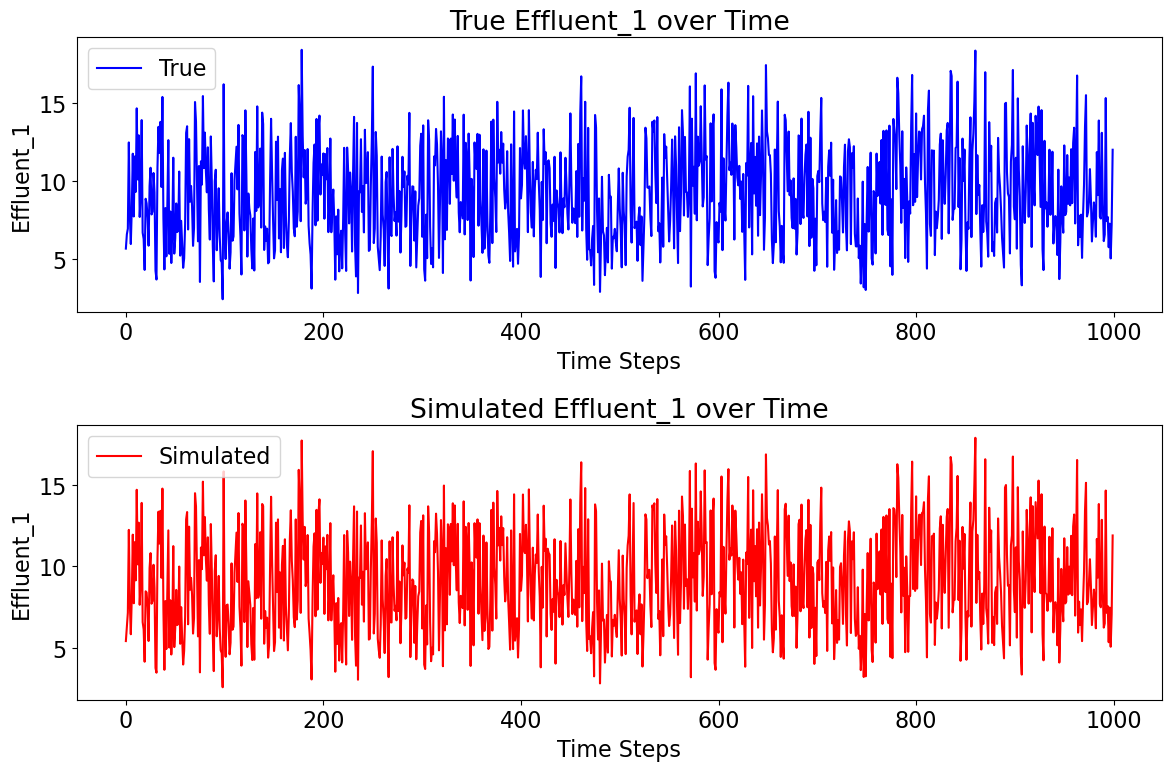

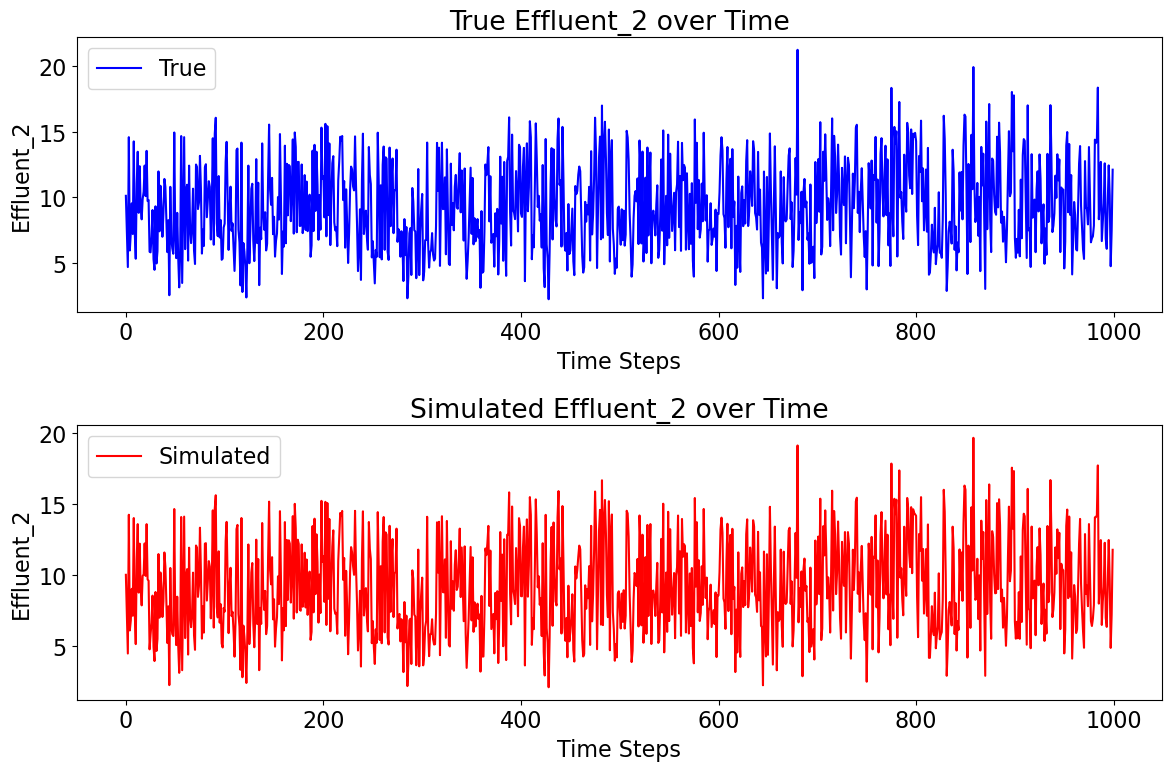

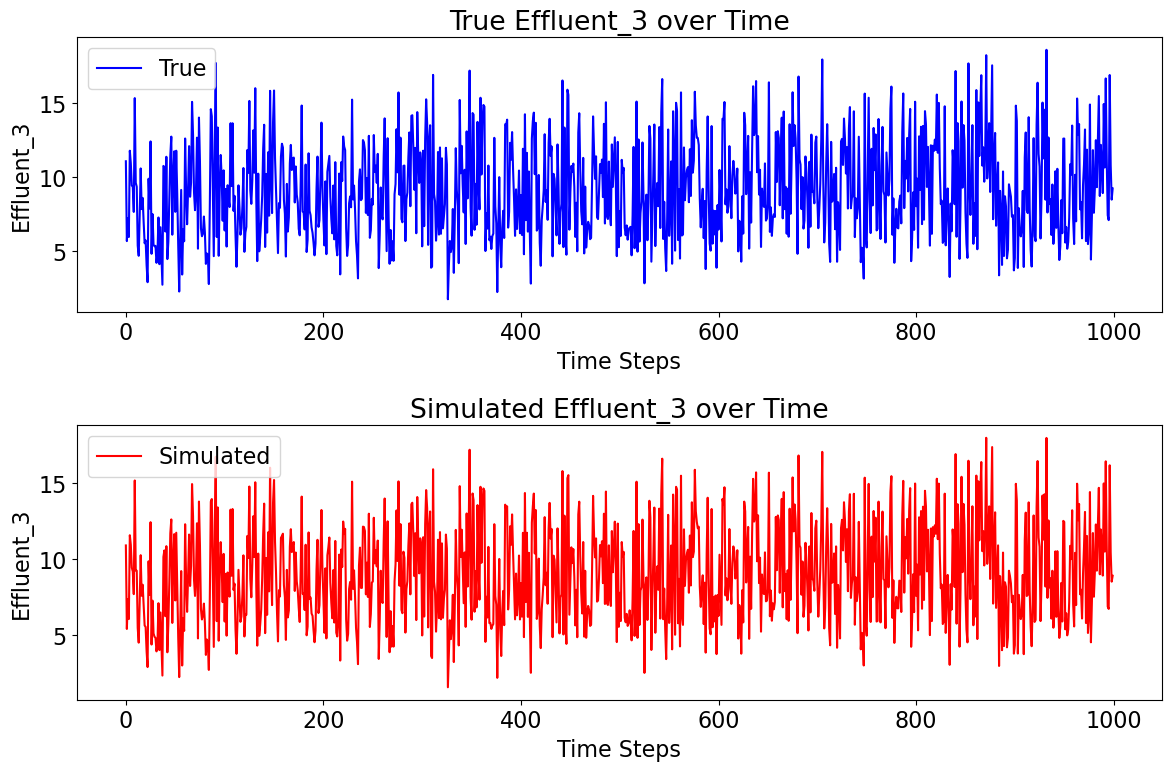

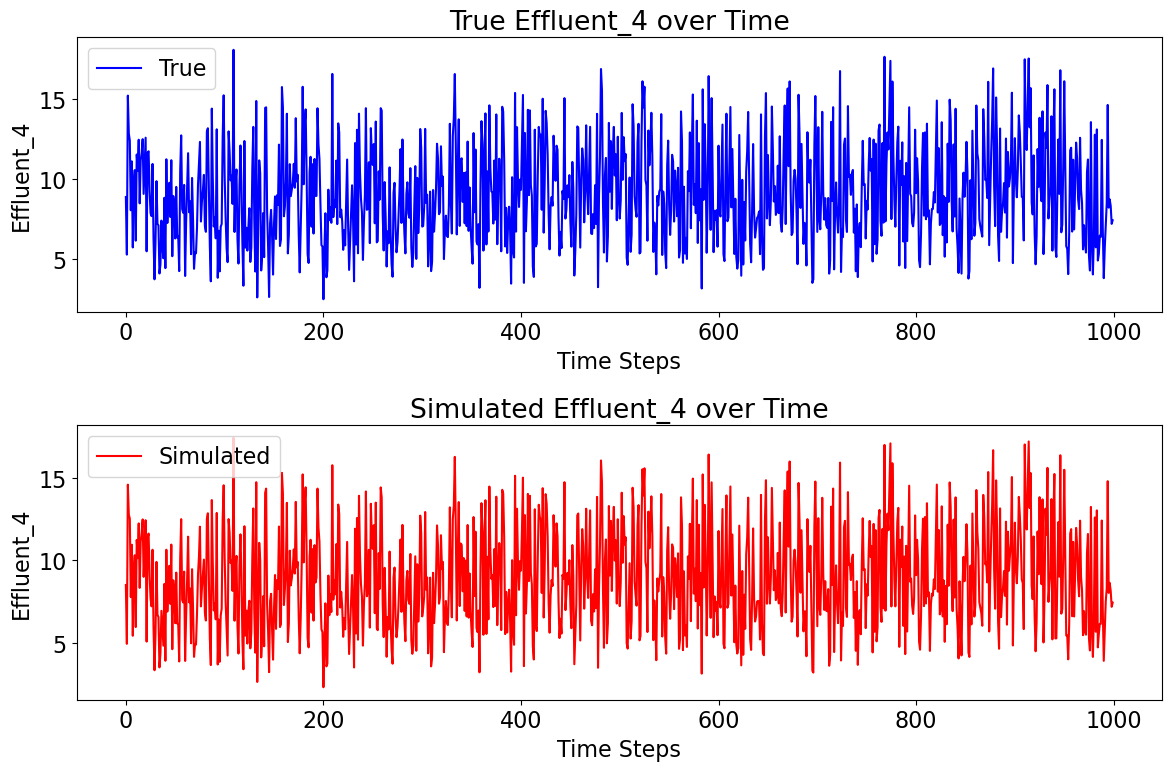

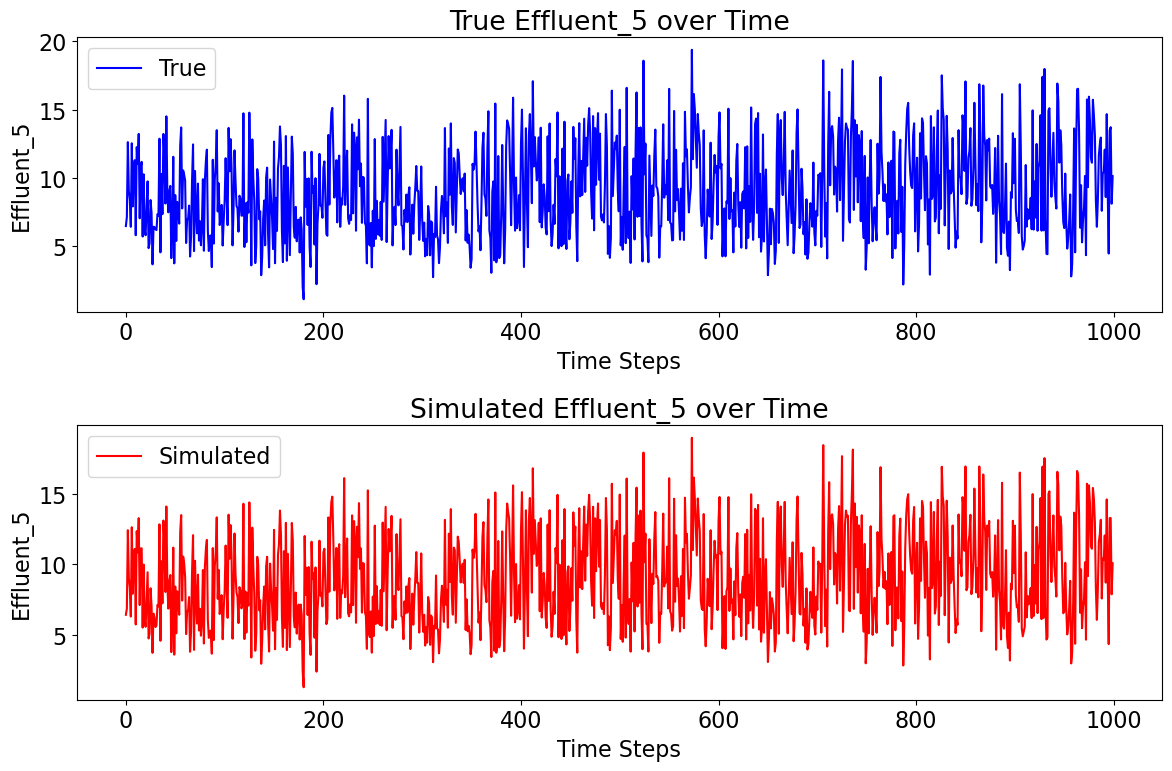

In [23]:
# 记录开始时间
start_time = time.time()

outputs = []

# 获取当前时间
current_time = torch.tensor(df.iloc[val_cutoff, :2].values, dtype=torch.float32)
print("模拟开始的时间（[Day, Hour]）：")
print(current_time)

# 获取过去100行数据作为 past_data_tensor
past_data_tensor = torch.tensor(df.iloc[val_cutoff - 100:val_cutoff, 2:].values, dtype=torch.float32)
print("\n过去一段时间的进水水质、药剂投加量和出水水质：")
print(past_data_tensor)
print(f"此张量的形状：{past_data_tensor.shape}")
print("")

# 初始化模拟器，使用 LSTMModel
simulator_LSTM = WaterTreatmentSimulator_LSTM(model_LSTM, preprocessor, SEQ_LENGTH, past_data_tensor, current_time)

for i in range(len(test_df)):
    current_influent_dosage_tensor = torch.tensor(
        df.iloc[val_cutoff + i, 2:simulator_LSTM.input_dim_1].values,  # 使用 simulator_LSTM 获取 input_dim_1
        dtype=torch.float32
    ).unsqueeze(0)

    # 模拟投加药剂！
    output = simulator_LSTM.simulate_dosage(current_influent_dosage_tensor)  # 使用 simulator_LSTM

    # 记录投加药剂后的出水水质
    outputs.append(output.squeeze(0).numpy())

outputs = np.array(outputs)

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"共模拟{len(test_df)}次药剂投加")
print(f"运行时间: {hours}时{minutes}分{seconds}秒")
print("")


# 获取真实出水水质
effluent_cols = [col for col in df.columns if col.startswith("Effluent")]
true_effluent = df.loc[val_cutoff:, effluent_cols].values

# 计算指标
mae = mean_absolute_error(true_effluent, outputs)
mape = mean_absolute_percentage_error(true_effluent, outputs) * 100
mae_percentage = (mae / np.mean(true_effluent)) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE Percentage of Average True Effluent: {mae_percentage:.2f}%")
print("")

print("真实出水水质与模拟器产出对比：")

# 绘图
time_steps = range(len(true_effluent))
for i, col in enumerate(effluent_cols):
    plt.figure(figsize=(12, 8))  # 增大图形高度以容纳更大的间距

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_effluent[:, i], label="True", color="blue") # 蓝色表示真实值
    plt.title(f"True {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_steps, outputs[:, i], label="Simulated", color="red") # 红色表示模拟值
    plt.title(f"Simulated {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.tight_layout() # 增加 pad 参数以增大子图间距
    plt.show()
    print("")

#### Transformer模拟器

模拟开始的时间（[Day, Hour]）：
tensor([11.,  0.])

过去一段时间的进水水质、药剂投加量和出水水质：
tensor([[10.6130,  4.4732,  2.5104,  ...,  3.8639,  9.4513,  6.7686],
        [ 2.5693,  6.0374,  3.6156,  ...,  6.5255, 10.0954,  3.6149],
        [ 7.5634,  4.6130,  5.2153,  ...,  8.1664, 13.1381, 10.6257],
        ...,
        [ 9.2136,  9.7948,  6.7644,  ...,  9.1849, 16.4461,  4.3875],
        [ 8.7270,  0.0522,  5.1149,  ...,  9.2316,  9.1489,  4.6258],
        [-0.1341,  4.8507,  4.3875,  ...,  7.9384, 12.3887,  7.9469]])
此张量的形状：torch.Size([100, 15])

共模拟1000次药剂投加
运行时间: 0时0分2秒

MAE: 0.1136
MAPE: 1.42%
MAE Percentage of Average True Effluent: 1.24%

真实出水水质与模拟器产出对比：


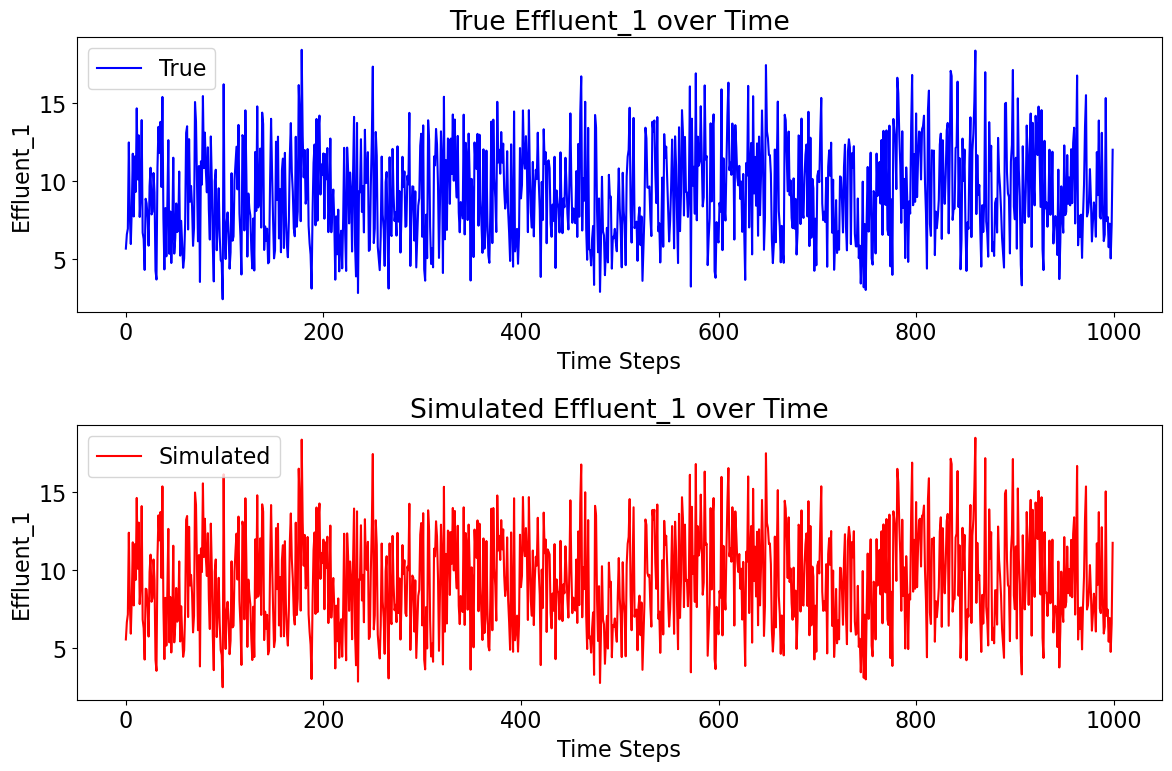

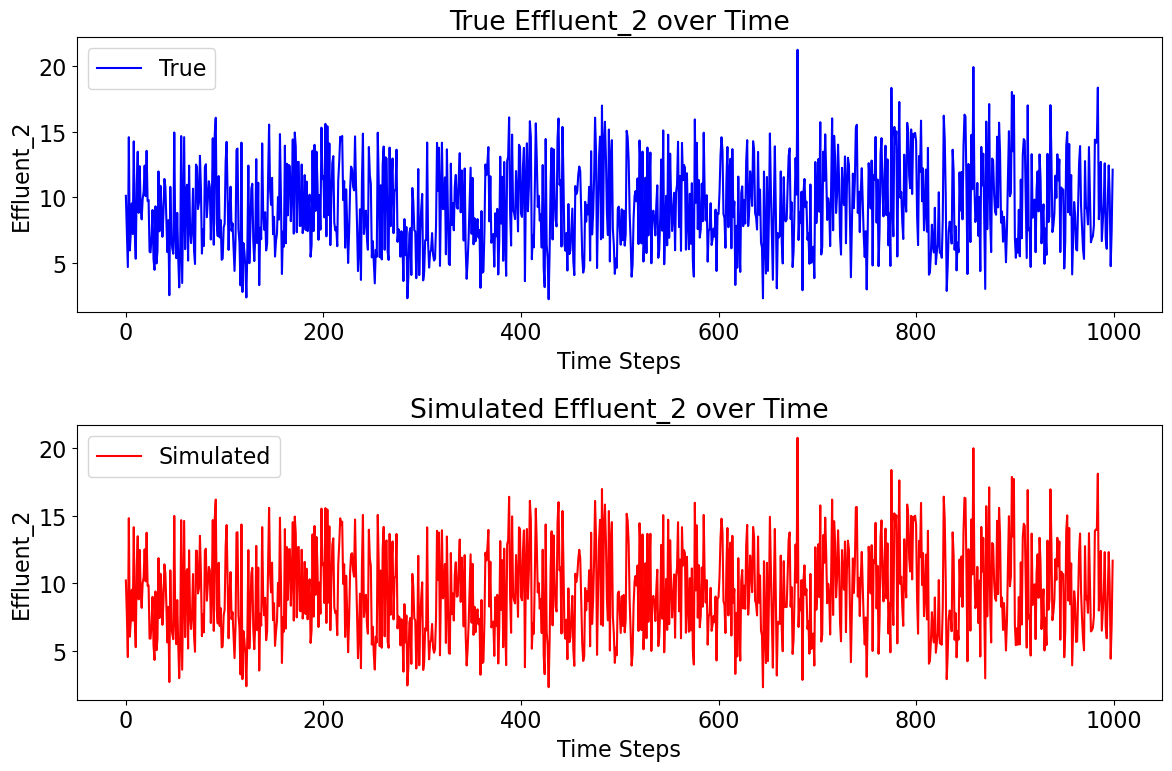

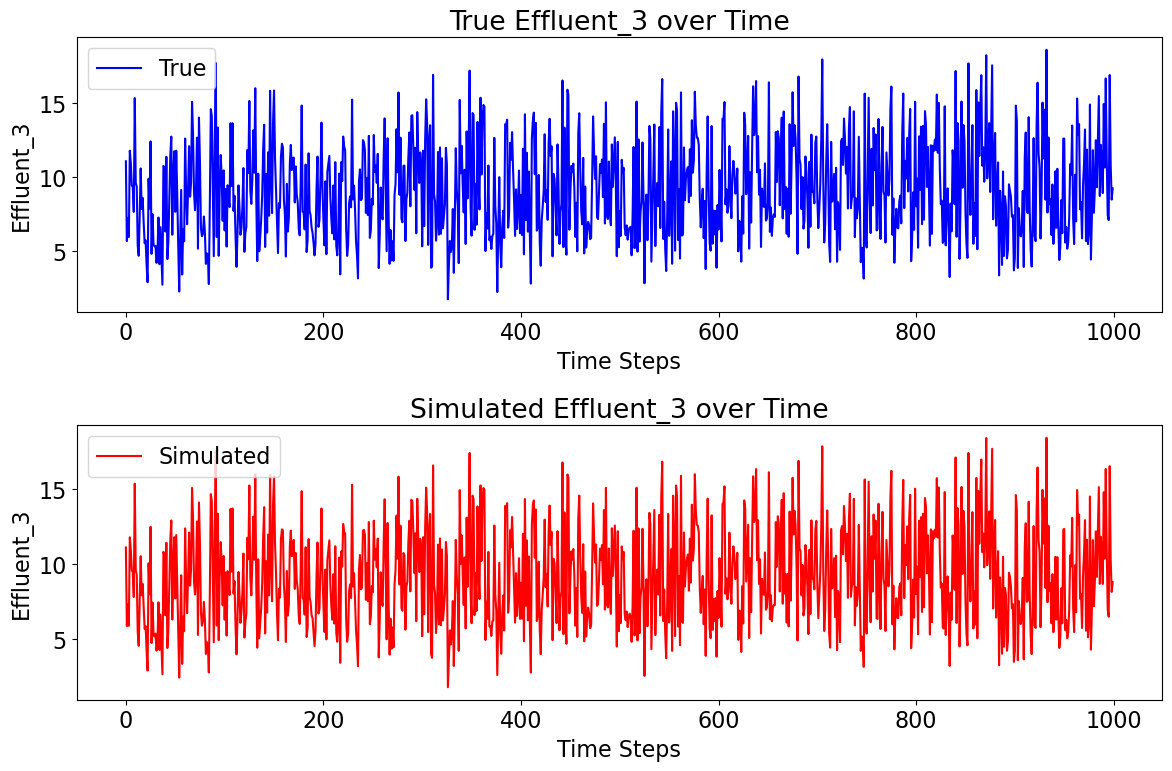

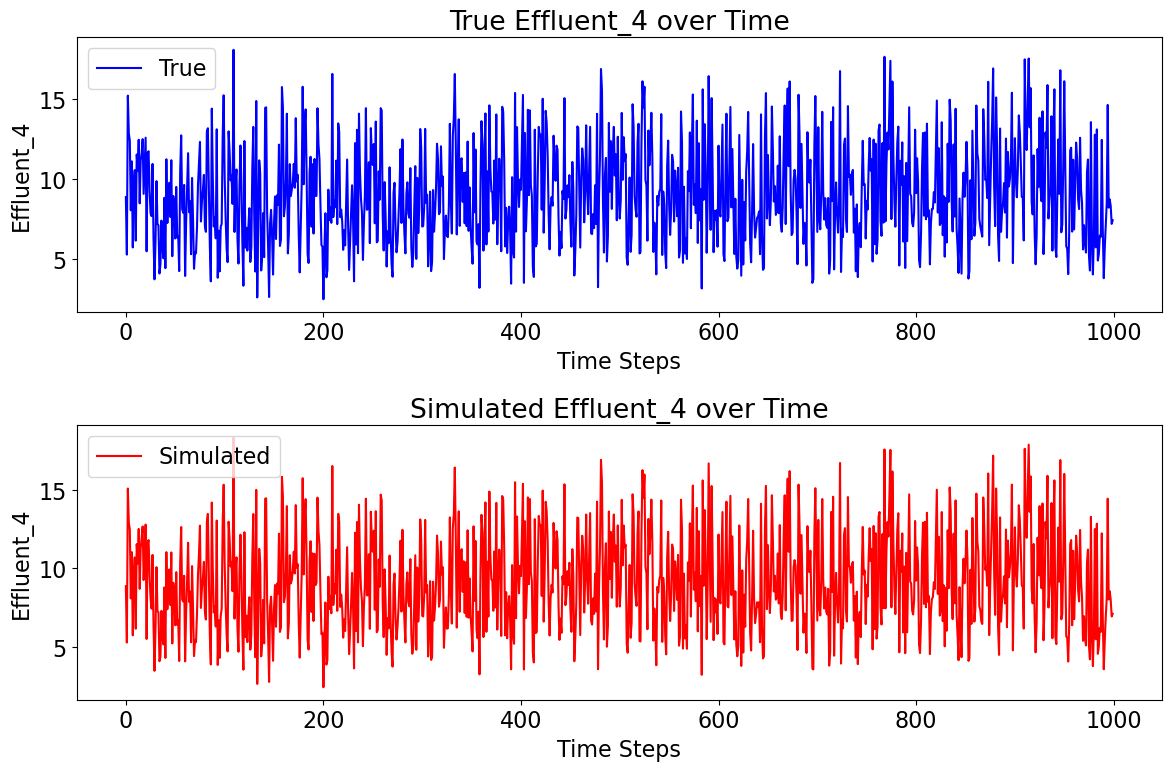

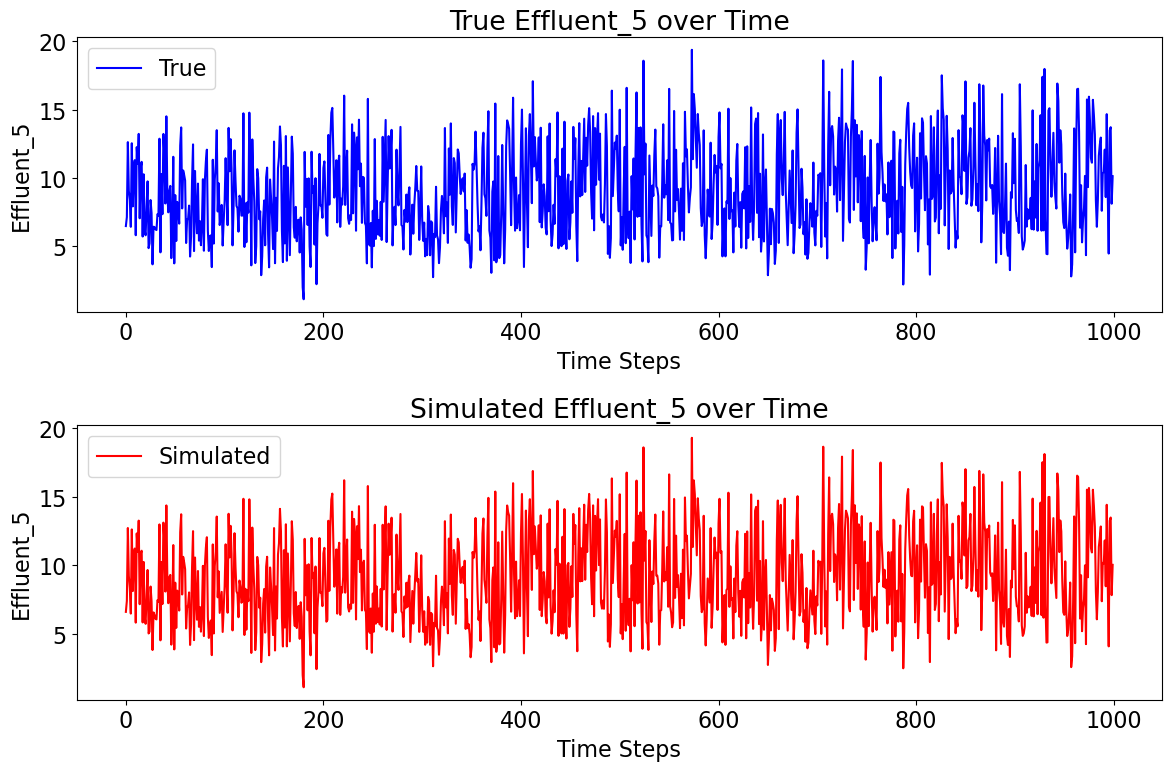

In [24]:
# 记录开始时间
start_time = time.time()

outputs = []

# 获取当前时间
current_time = torch.tensor(df.iloc[val_cutoff, :2].values, dtype=torch.float32)
print("模拟开始的时间（[Day, Hour]）：")
print(current_time)

# 获取过去100行数据作为 past_data_tensor
past_data_tensor = torch.tensor(df.iloc[val_cutoff - 100:val_cutoff, 2:].values, dtype=torch.float32)
print("\n过去一段时间的进水水质、药剂投加量和出水水质：")
print(past_data_tensor)
print(f"此张量的形状：{past_data_tensor.shape}")
print("")

# 初始化模拟器，使用 TransformerModel
simulator_Transformer = WaterTreatmentSimulator_Transformer(
    model_Transformer_Tuned, preprocessor, Param_Dict_Transformer["seq_len"], 
    past_data_tensor, current_time)

for i in range(len(test_df)):
    current_influent_dosage_tensor = torch.tensor(
        df.iloc[val_cutoff + i, 2:simulator_Transformer.input_dim_1].values, dtype=torch.float32
    ).unsqueeze(0)

    # 模拟投加药剂！
    output = simulator_Transformer.simulate_dosage(current_influent_dosage_tensor)

    # 记录投加药剂后的出水水质
    outputs.append(output.squeeze(0).numpy())

outputs = np.array(outputs)

# 记录结束时间
end_time = time.time()
# 计算总运行时间
total_time = end_time - start_time
# 将总运行时间转换为几时几分几秒的格式
td = timedelta(seconds=total_time)
hours = td.seconds // 3600
minutes = (td.seconds % 3600) // 60
seconds = td.seconds % 60
# 打印总运行时间
print(f"共模拟{len(test_df)}次药剂投加")
print(f"运行时间: {hours}时{minutes}分{seconds}秒")
print("")


# 获取真实出水水质
effluent_cols = [col for col in df.columns if col.startswith("Effluent")]
true_effluent = df.loc[val_cutoff:, effluent_cols].values

# 计算指标
mae = mean_absolute_error(true_effluent, outputs)
mape = mean_absolute_percentage_error(true_effluent, outputs) * 100
mae_percentage = (mae / np.mean(true_effluent)) * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE Percentage of Average True Effluent: {mae_percentage:.2f}%")
print("")

print("真实出水水质与模拟器产出对比：")

# 绘图
time_steps = range(len(true_effluent))
for i, col in enumerate(effluent_cols):
    plt.figure(figsize=(12, 8))  # 增大图形高度以容纳更大的间距

    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_effluent[:, i], label="True", color="blue") # 蓝色表示真实值
    plt.title(f"True {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_steps, outputs[:, i], label="Simulated", color="red") # 红色表示模拟值
    plt.title(f"Simulated {col} over Time")
    plt.xlabel("Time Steps")
    plt.ylabel(col)
    plt.legend()

    plt.tight_layout() # 增加 pad 参数以增大子图间距
    plt.show()
    print("")

## 结论

**泛化到波动较大的情况下值得探讨**：

LSTM （也包括其它循环神经网络模型如 GRU）虽然能够捕捉长期依赖，但它本质上仍然是基于局部信息的处理方式。它的记忆是通过链式结构传递的，信息在长距离传递过程中可能会逐渐衰减或丢失。这使得 LSTM 在处理非常长序列或者突发性剧烈变化时，可能难以有效捕捉全局信息和长期模式。在波动较小的数据上训练，LSTM 倾向于学习到一种“平滑”的模式，对未来的预测也趋于平稳。当遇到水质突变时，LSTM 可能难以快速响应。

Transformer 的核心是自注意力机制，它能够直接捕捉序列中任意两个位置之间的关系，无需像 LSTM 那样依赖链式结构传递信息。 这使得 Transformer 能够更好地捕捉全局信息和长期模式，对突发性变化的响应也更加迅速。